-----
# 02 - Unibiomarker Analysis

In [1]:
from pathlib import Path
import seaborn as sns
import pandas as pd

from utils import format_dataframe, add_ratio_columns
from unibiomarker import Unibiomarker
import constants

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Default Plot Style : 
sns.set(style="whitegrid")


## 1. Data Loading & Preparation

In [2]:
# Set path to Data Directory : 
DIR_DATA = Path.cwd() / "data"

# Check existence to training/test files : 
print(fr"Data Directory    : {str(DIR_DATA)}")
print(fr"Train Data exists : {(DIR_DATA / 'cercare_training_data.xlsx').exists()}")
print(fr"Test Data exists  : {(DIR_DATA / 'cercare_test_data.xlsx').exists()}")


Data Directory    : C:\Users\maichi\work\my_projects\CercareStatAnalysis\data
Train Data exists : True
Test Data exists  : True


In [3]:
# Load Cercare Training / Test Excel spreadsheets :
df_data = pd.read_excel(DIR_DATA / "cercare_training_data.xlsx").rename(columns=constants.DICT_RENAMING_MAPPING)
df_test = pd.read_excel(DIR_DATA / "cercare_test_data.xlsx").rename(columns=constants.DICT_RENAMING_MAPPING)

# Format dataframes : 
df_data = format_dataframe(df=df_data)
df_test = format_dataframe(df=df_test)

# Add the ratio columns : 
add_ratio_columns(df_data)
add_ratio_columns(df_test)

print("Data Loaded and formatted Successfully ! ")


Data Loaded and formatted Successfully ! 


##  2. 🔧  Configuration 

In [4]:
BIOMARKER = "CBV_corr"  # Choose from :  ADC, CBV_corr, CBV_noncorr, DELAY, CTH, CTH MAX, OEF, rLEAKAGE, rCMRO2, COV

In [5]:
# Unibiomarker object Initialization : 
ub = Unibiomarker(name=BIOMARKER, data = df_data, test_data=df_test)
print(ub)


Biomarker object
- Parameters: CBV_corr_path, CBV_corr_control, CBV_corr_ratio
- Training samples: 182
- Test samples: 23



## 3. Descriptive Analysis

### 3.1 Check for missing values

Fully usable rows in train: 170/182 (93.4%)
Fully usable rows in test:  23/23 (100.0%)


,Train Missing %,Test Missing %
CBV_corr_path,6.0,0.0
CBV_corr_control,2.2,0.0
CBV_corr_ratio,6.6,0.0


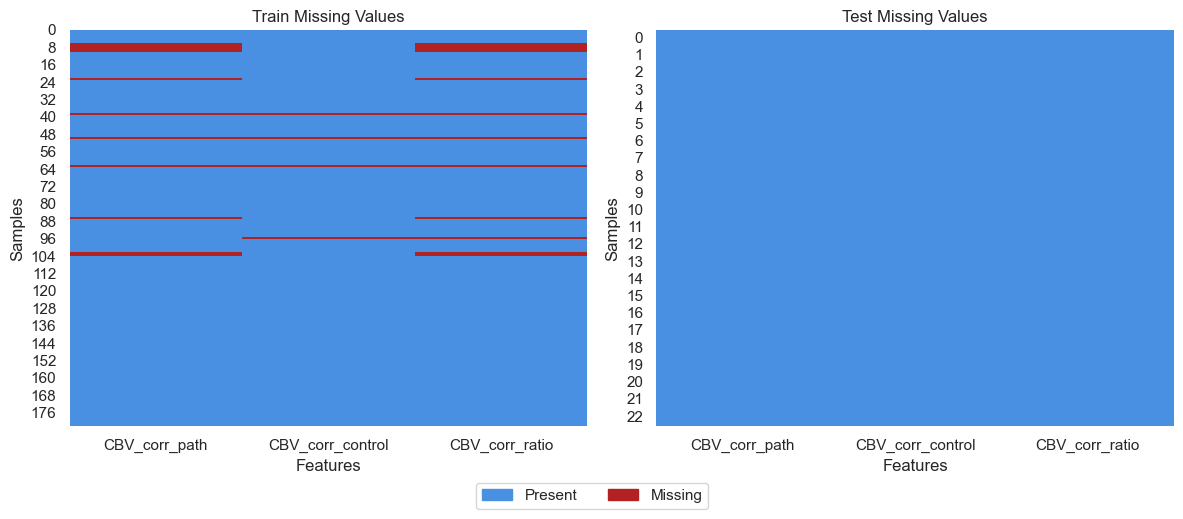

In [6]:
ub.check_missing_data()


### 3.2 Describe & Visualize key features

In [7]:
ub.describe_features(features=[ub.path, ub.control])


Overall Descriptive Statistics : 


,count,mean,std,min,25%,50%,75%,max
CBV_corr_path,171.0,3.295322,2.931245,0.20,1.4100,2.23,4.475,18.24
CBV_corr_control,178.0,3.131067,1.933728,0.12,2.0825,2.82,3.740,17.00



Descriptive Statistics by 'Diagnosis' Class:


,Feature,Class,count,mean,std,min,25%,50%,75%,max
0,CBV_corr_path,0,104.0,2.096923,1.800850,0.20,1.150,1.66,2.4825,11.00
2,CBV_corr_path,1,67.0,5.155522,3.360723,1.12,2.535,4.91,6.6800,18.24
1,CBV_corr_control,0,110.0,3.635636,2.156739,0.73,2.640,3.19,4.1325,17.00
3,CBV_corr_control,1,68.0,2.314853,1.103141,0.12,1.815,2.29,3.0000,5.08


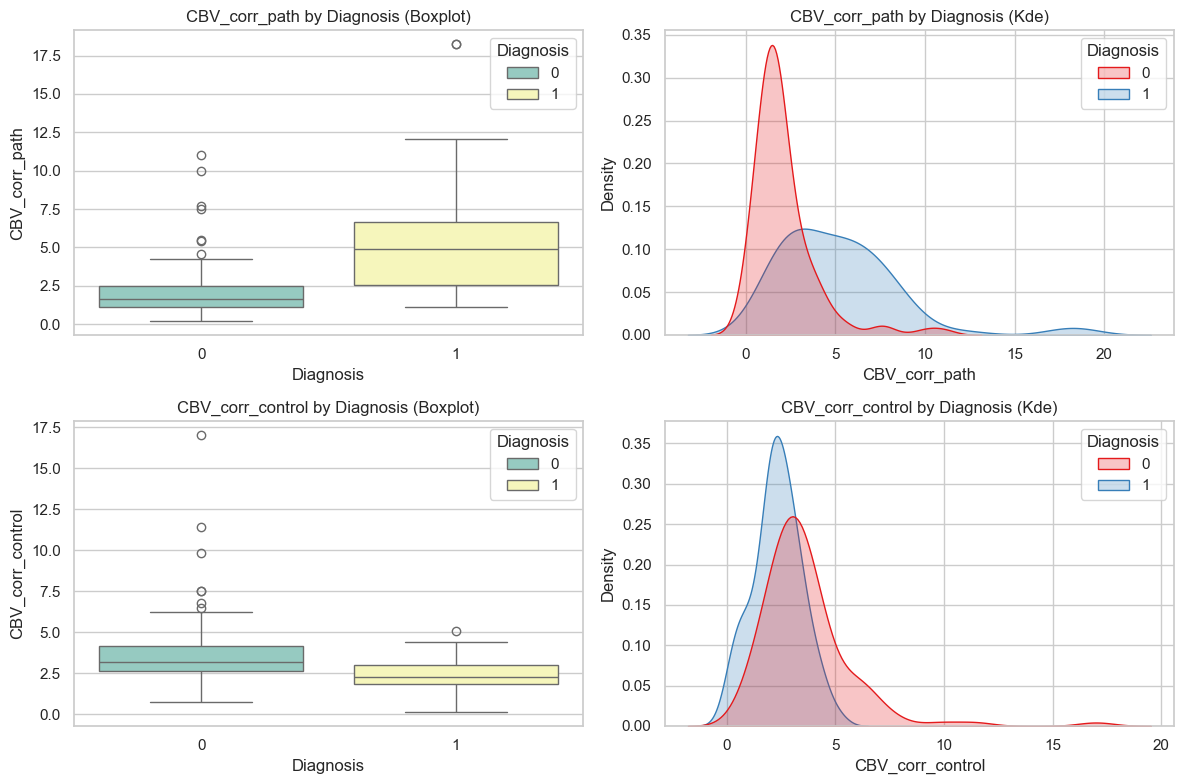

In [8]:
ub.plot_feature_distributions(features=[ub.path, ub.control], plots=["boxplot", "kde"])


### 3.3 Ratio Analysis

The goal of this section is to check correlation between the path variable and the control variable

The ratio is defined as:  
**`Ratio = Path / Control`**

To assess whether this ratio provides *new, meaningful information*, we first examine the correlation between `Path` and `Control` values:

---

#### 🔍 What we check

1. **Pearson correlation** (linear relationship)  
   Measures the strength of a **linear** association between `Path` and `Control`.

   $$
   r = \frac{\text{Cov}(X, Y)}{\sigma_X \cdot \sigma_Y}
   $$

2. **Spearman correlation** (monotonic relationship)  
   Applies the Pearson formula to the **ranked values** rather than raw values.

   $$
   \rho = \frac{\text{Cov}(\text{Rank}(X), \text{Rank}(Y))}{\sigma_{\text{Rank}(X)} \cdot \sigma_{\text{Rank}(Y)}}
   $$

   This makes Spearman suitable for detecting **monotonic relationships** that are not necessarily linear.

3. **Statistical significance** (p-values)  
   For both Pearson and Spearman, a **p-value** tests the null hypothesis that the correlation is zero (i.e., no association exists):

   - A **low p-value** (typically < 0.05) indicates that the correlation is **statistically significant**  
   - A **high p-value** means there is **insufficient evidence** to conclude that a statistically significant correlation exists
     

In [9]:
ub.describe_features(features=[ub.ratio])

Overall Descriptive Statistics : 


,count,mean,std,min,25%,50%,75%,max
CBV_corr_ratio,170.0,1.644008,2.993394,0.080321,0.435606,0.69496,1.977531,30.8



Descriptive Statistics by 'Diagnosis' Class:


,Feature,Class,count,mean,std,min,25%,50%,75%,max
0,CBV_corr_ratio,0,104.0,0.619576,0.578714,0.080321,0.344866,0.482143,0.639098,4.545455
1,CBV_corr_ratio,1,66.0,3.258266,4.294334,0.289370,1.563981,2.550439,3.257191,30.800000


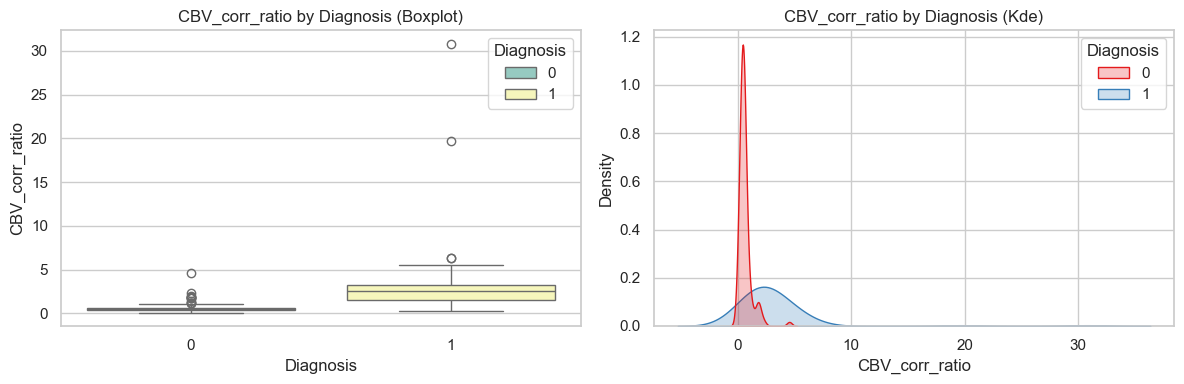

In [10]:
ub.plot_feature_distributions(features=[ub.ratio], plots=["boxplot", "kde"])

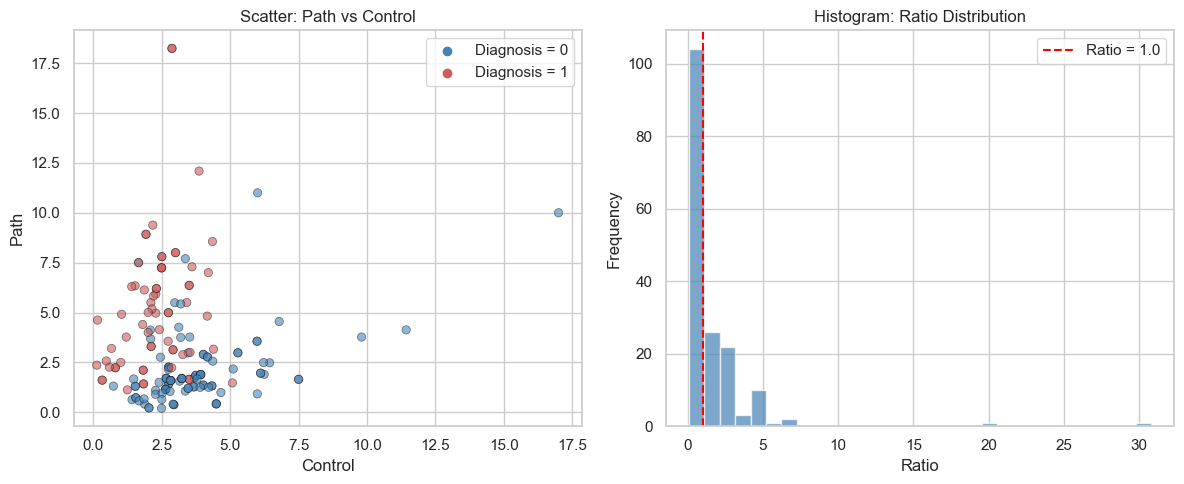

In [11]:
ub.plot_diagnostic_scatter_and_ratio()

In [12]:
ub.evaluate_path_control_correlation()

🔍 Analyzing Biomarker: CBV_corr
------------------------------------------------------------------------------------------------------------------------------------------------------
--- Step 1: Correlation Analysis between Path and Control 
------------------------------------------------------------------------------------------------------------------------------------------------------
- Pearson  correlation: r = 0.074, p = 0.3352
- Spearman correlation: r = -0.010, p = 0.8940

------------------------------------------------------------------------------------------------------------------------------------------------------
--- Step 2: Interpretation Guidance 
------------------------------------------------------------------------------------------------------------------------------------------------------
Neither Pearson nor Spearman correlation is statistically significant ! 
No clear association between Path and Control ! 
The ratio is a worthwhile feature to explore ! 


## 4.  Discriminative Power of the Biomarker


In this section, we assess whether features like `path` and `ratio` can **discriminate between diagnostic groups**, such as Tumor Recurrence and Radiation Necrosis.

---

#### Step 1 – Normality Check

We start with **Q–Q plots** to visually evaluate whether the distribution of the feature within each group appears **approximately normal**. This helps decide whether we can meaningfully apply a parametric test that models the **data distribution**.

---
#### Step 2 – Choosing the Right Statistical Test

- If the feature appears **normally distributed** in each group, we apply a **Welch’s t-test**.
  - This test assumes the data follows a normal distribution and compares the **means** between groups.
  - Using a parametric test like this is valuable because it lets us **model the data with a known distribution**

- If the feature **does not appear normally distributed**, we instead use the **Mann–Whitney U test**.
  - This is a **non-parametric** test that compares whether values in one group tend to be higher or lower than in the other.
  - It doesn’t assume any specific distribution and works on **ranked data** rather than actual values.
  - But it doesn’t let us **model or describe the underlying distribution** of the data 

---

#### Step 3 – Interpreting the Results

If either test reports a **statistically significant difference** (typically p < 0.05), it suggests that the feature behaves differently between groups — a necessary condition for it to be useful as a biomarker

### 4.1. Distribution Differences: Path Feature

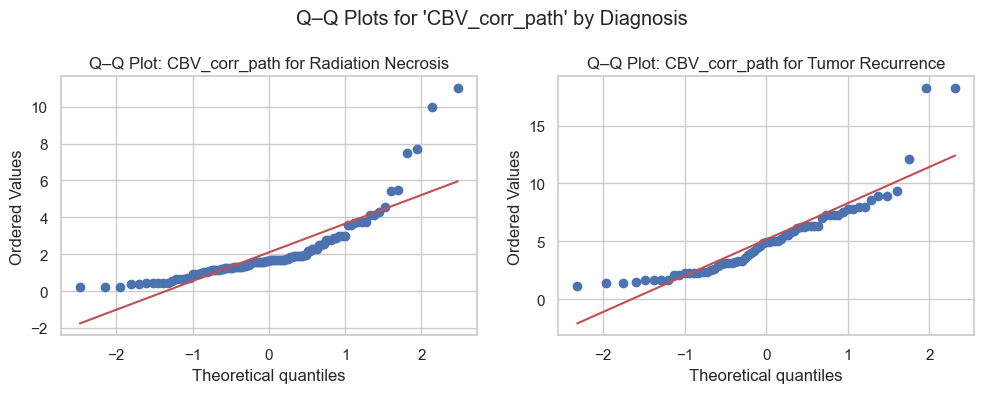

In [13]:
ub.plot_qq_by_group(feature=ub.path)

In [14]:
ub.test_group_difference(feature=ub.path)

Group Comparison Results:
----------------------------------------------------------------------------------------------------
Welch’s t-test       → statistic = -6.8434, p = 0.0000   → ✅ Significant difference
Mann–Whitney U test  → statistic = 1082.0000, p = 0.0000   → ✅ Significant difference



🔎 [ROC-Based Classification] Feature: 'CBV_corr_path'
--------------------------------------------------------------------------------
AUC (Train) : 0.845  (95% CI: 0.786 – 0.904)
AUC (Test)  : 0.696  (95% CI: 0.464 – 0.928)

 Optimal threshold (Youden’s J): 2.110
 Classification Rule          : Class = 1 if CBV_corr_path ≥ 2.110

▶ TRAIN SET METRICS AT THRESHOLD: 2.110
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      76.6
Recall (Sensitivity) |      88.1
Specificity          |      69.2
Precision            |      64.8
F1 Score             |      74.7

▶ TEST SET METRICS AT THRESHOLD: 2.110
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      60.9
Recall (Sensitivity) |      42.9
Specificity          |      68.8
Precision            |      37.5
F1 Score         

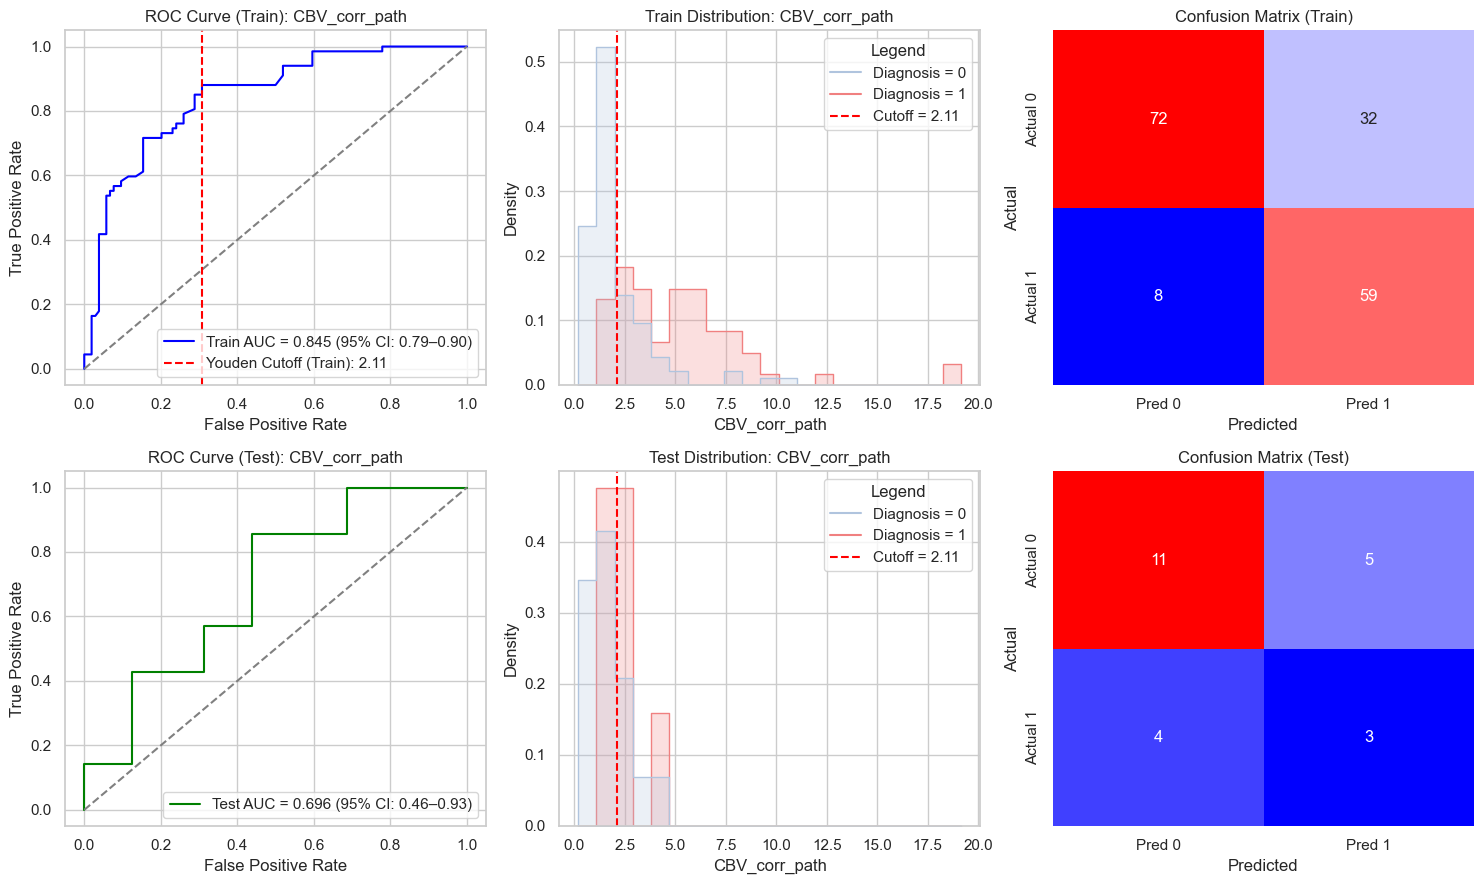

In [15]:
ub.evaluate_feature_predictive_power(feature=ub.path, target_bin_count=20)

### 4.2. Distribution Differences: Path Feature

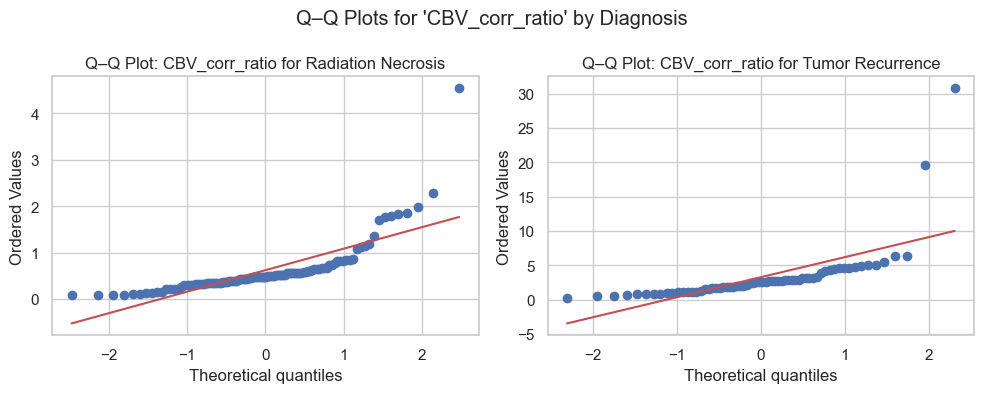

In [16]:
ub.plot_qq_by_group(feature=ub.ratio)

In [17]:
ub.test_group_difference(feature=ub.ratio)

Group Comparison Results:
----------------------------------------------------------------------------------------------------
Welch’s t-test       → statistic = -4.9634, p = 0.0000   → ✅ Significant difference
Mann–Whitney U test  → statistic = 477.5000, p = 0.0000   → ✅ Significant difference



🔎 [ROC-Based Classification] Feature: 'CBV_corr_ratio'
--------------------------------------------------------------------------------
AUC (Train) : 0.930  (95% CI: 0.890 – 0.971)
AUC (Test)  : 0.714  (95% CI: 0.478 – 0.951)

 Optimal threshold (Youden’s J): 0.850
 Classification Rule          : Class = 1 if CBV_corr_ratio ≥ 0.850

▶ TRAIN SET METRICS AT THRESHOLD: 0.850
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      87.6
Recall (Sensitivity) |      89.4
Specificity          |      86.5
Precision            |      80.8
F1 Score             |      84.9

▶ TEST SET METRICS AT THRESHOLD: 0.850
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      47.8
Recall (Sensitivity) |     100.0
Specificity          |      25.0
Precision            |      36.8
F1 Score       

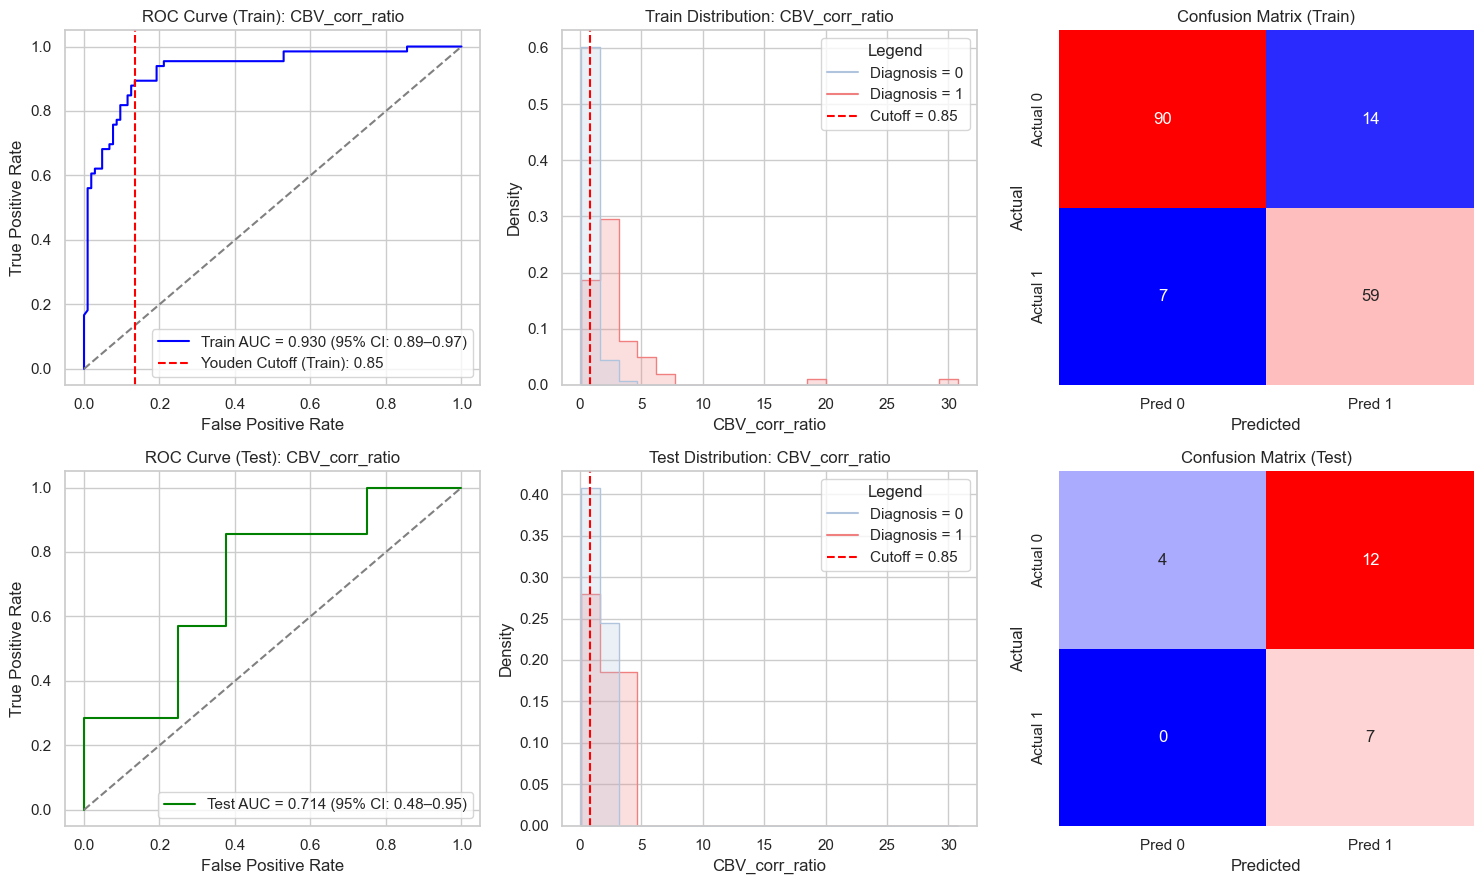

In [18]:
ub.evaluate_feature_predictive_power(feature=ub.ratio, target_bin_count=20)

## 5.  Logistic Regression Modelling

### 5.1 Univariate Logistic Regression 


Logistic Regression Summary for Feature: CBV_corr_path
----------------------------------------------------------------------------------------------------
Log-Odds Coefficient : 0.5734
Odds Ratio           : 1.7742
Youden's J Threshold : 0.2569
----------------------------------------------------------------------------------------------------

--- Inference Using statsmodels ---
Odds Ratio (statsmodels)  : 1.7742
95% CI for OR             : (1.4618, 2.1535)
p-value                   : 6.6002e-09
----------------------------------------------------------------------------------------------------

▶ [CBV_CORR_PATH] TRAIN @ 0.5
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      77.8
Recall (Sensitivity) |      58.2
Specificity          |      90.4
Precision            |      79.6
F1 Score             |      67.2

▶ [CBV_CORR_PATH] TRAIN @ YOUDEN
-----------------------------

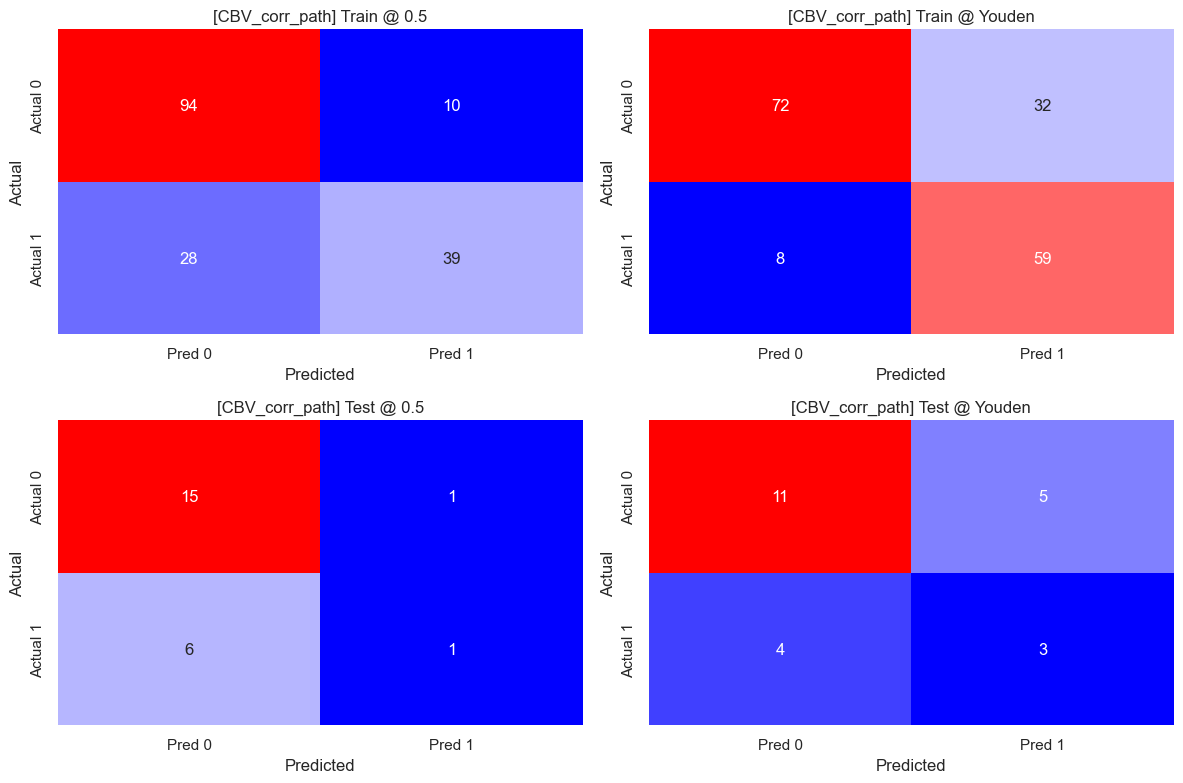

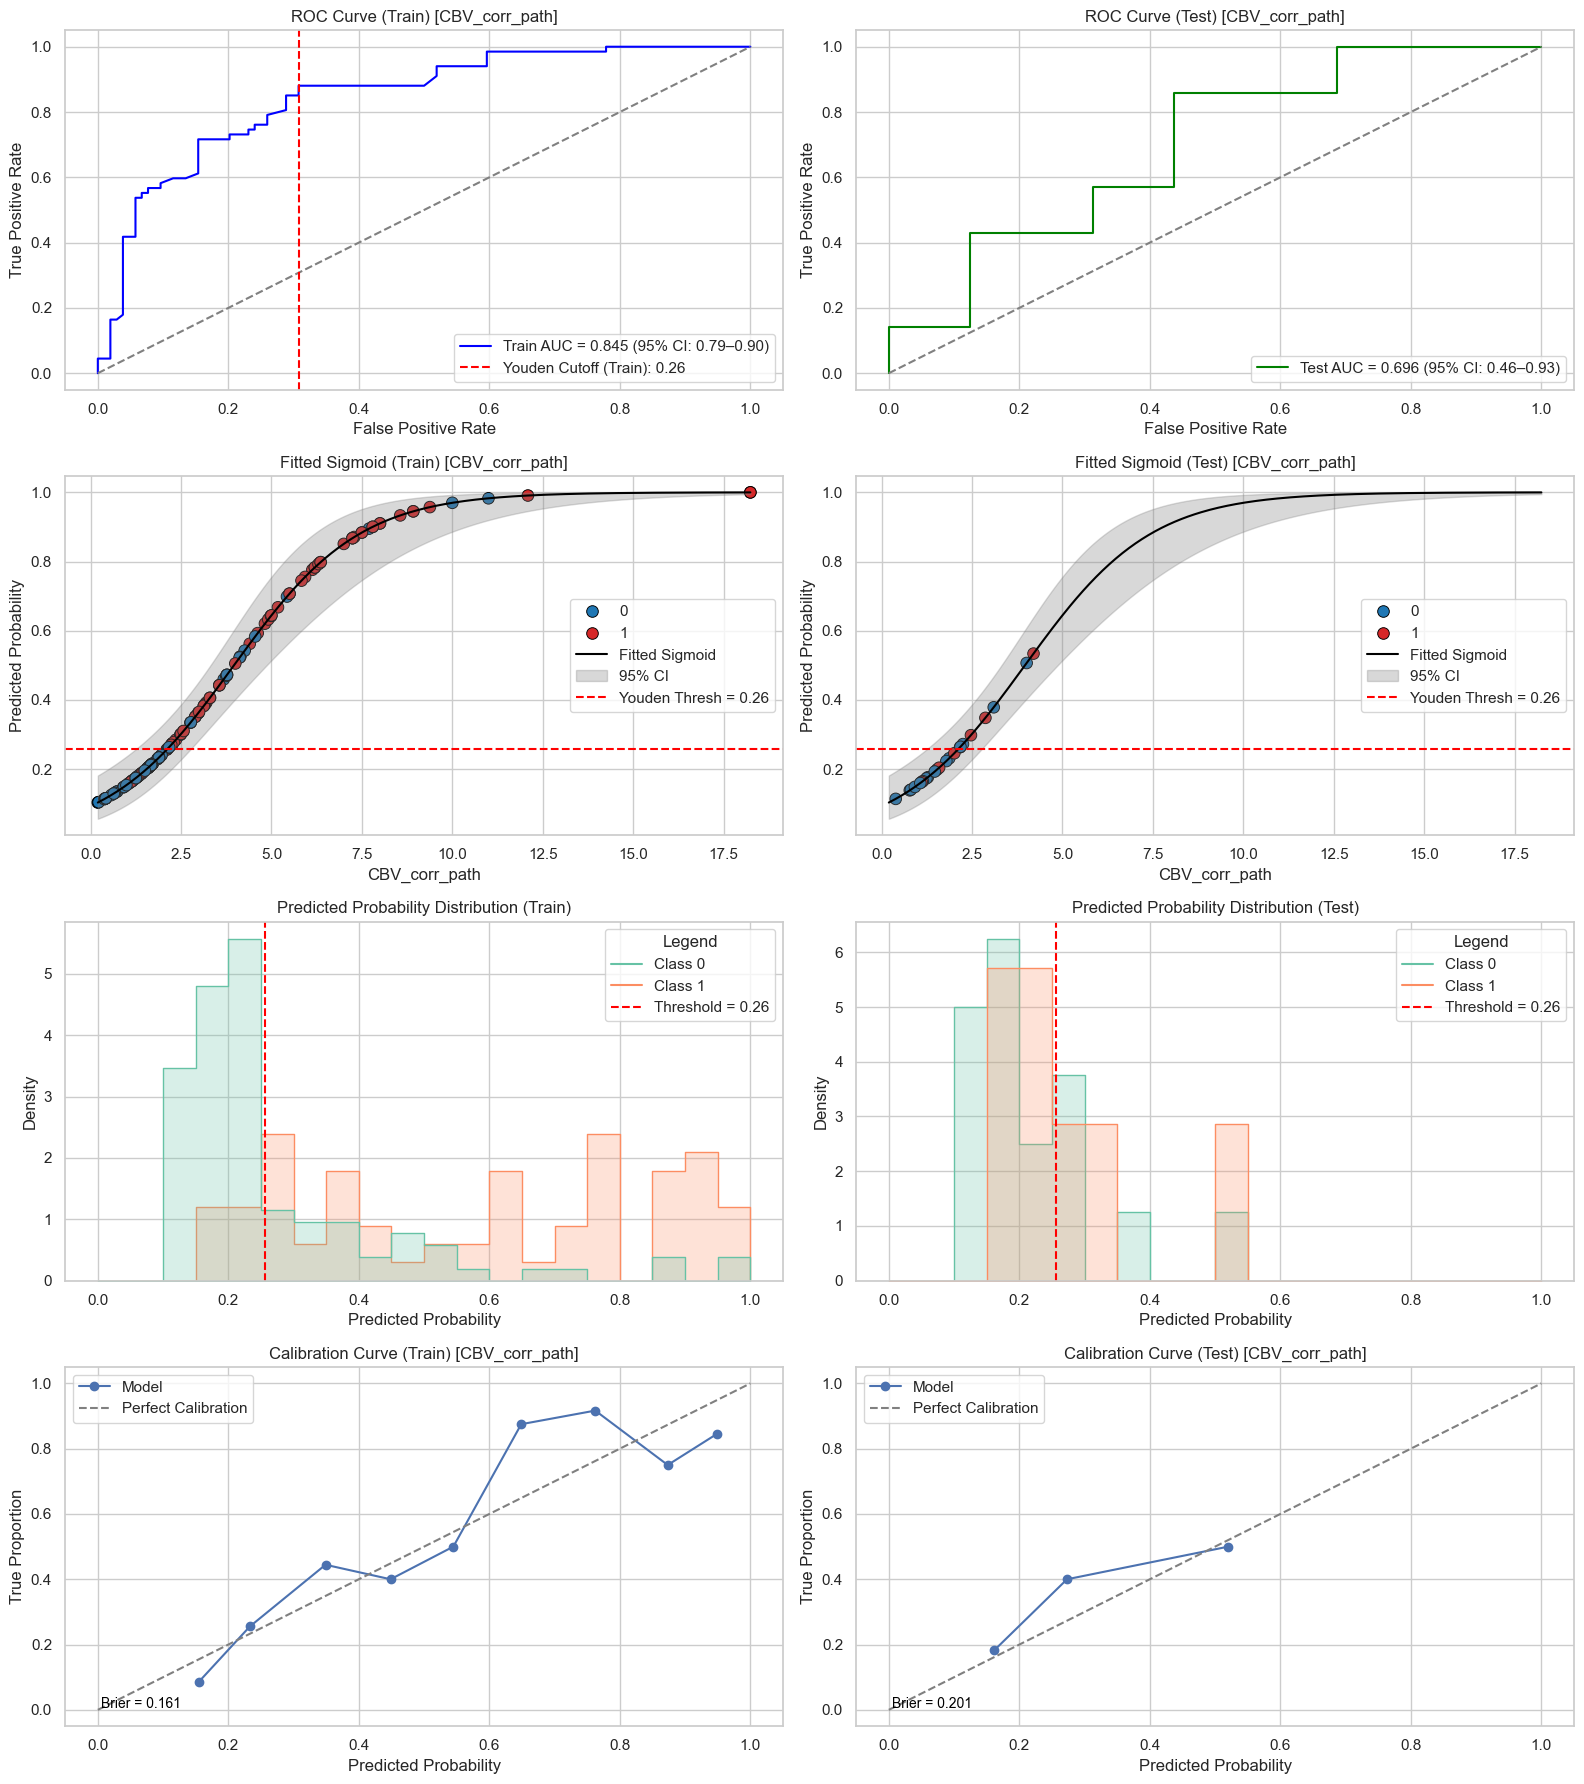

In [19]:
ub.evaluate_logistic_univariate_model(feature=ub.path, target_bin_count=20)


Logistic Regression Summary for Feature: CBV_corr_ratio
----------------------------------------------------------------------------------------------------
Log-Odds Coefficient : 2.1217
Odds Ratio           : 8.3450
Youden's J Threshold : 0.2151
----------------------------------------------------------------------------------------------------

--- Inference Using statsmodels ---
Odds Ratio (statsmodels)  : 8.3450
95% CI for OR             : (4.3776, 15.9079)
p-value                   : 1.1518e-10
----------------------------------------------------------------------------------------------------

▶ [CBV_CORR_RATIO] TRAIN @ 0.5
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      85.9
Recall (Sensitivity) |      75.8
Specificity          |      92.3
Precision            |      86.2
F1 Score             |      80.6

▶ [CBV_CORR_RATIO] TRAIN @ YOUDEN
-------------------------

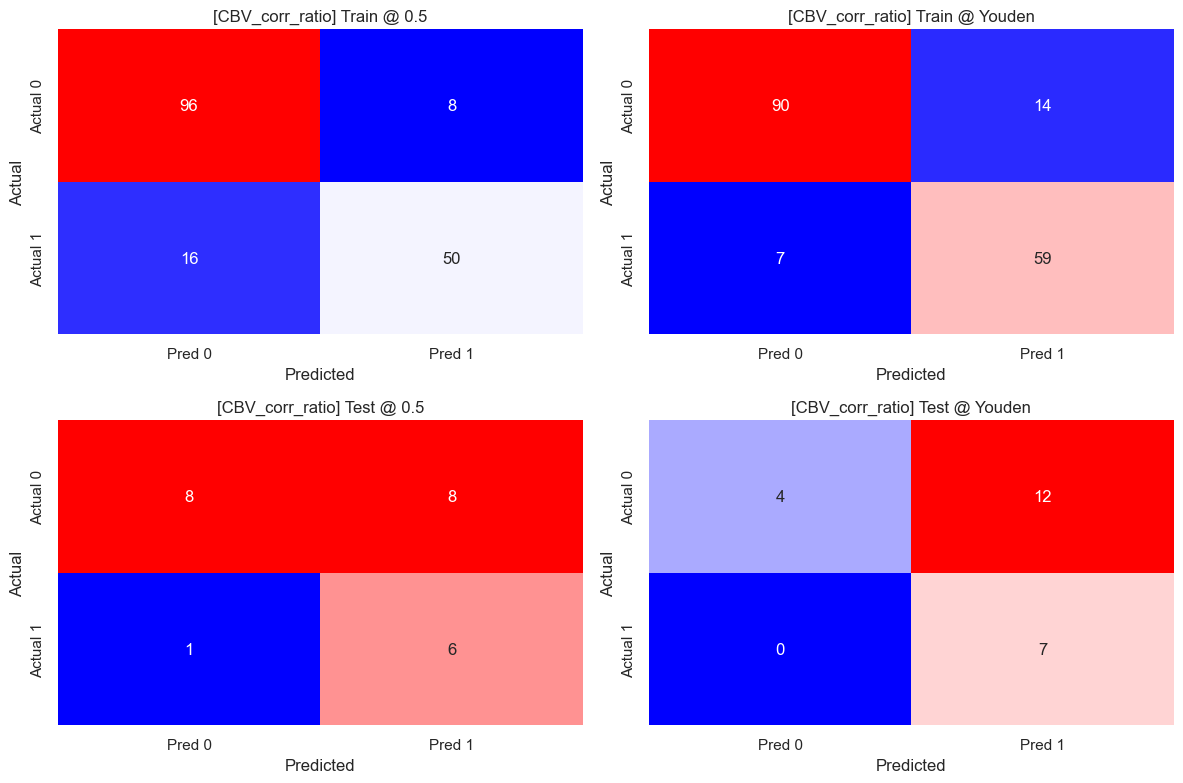

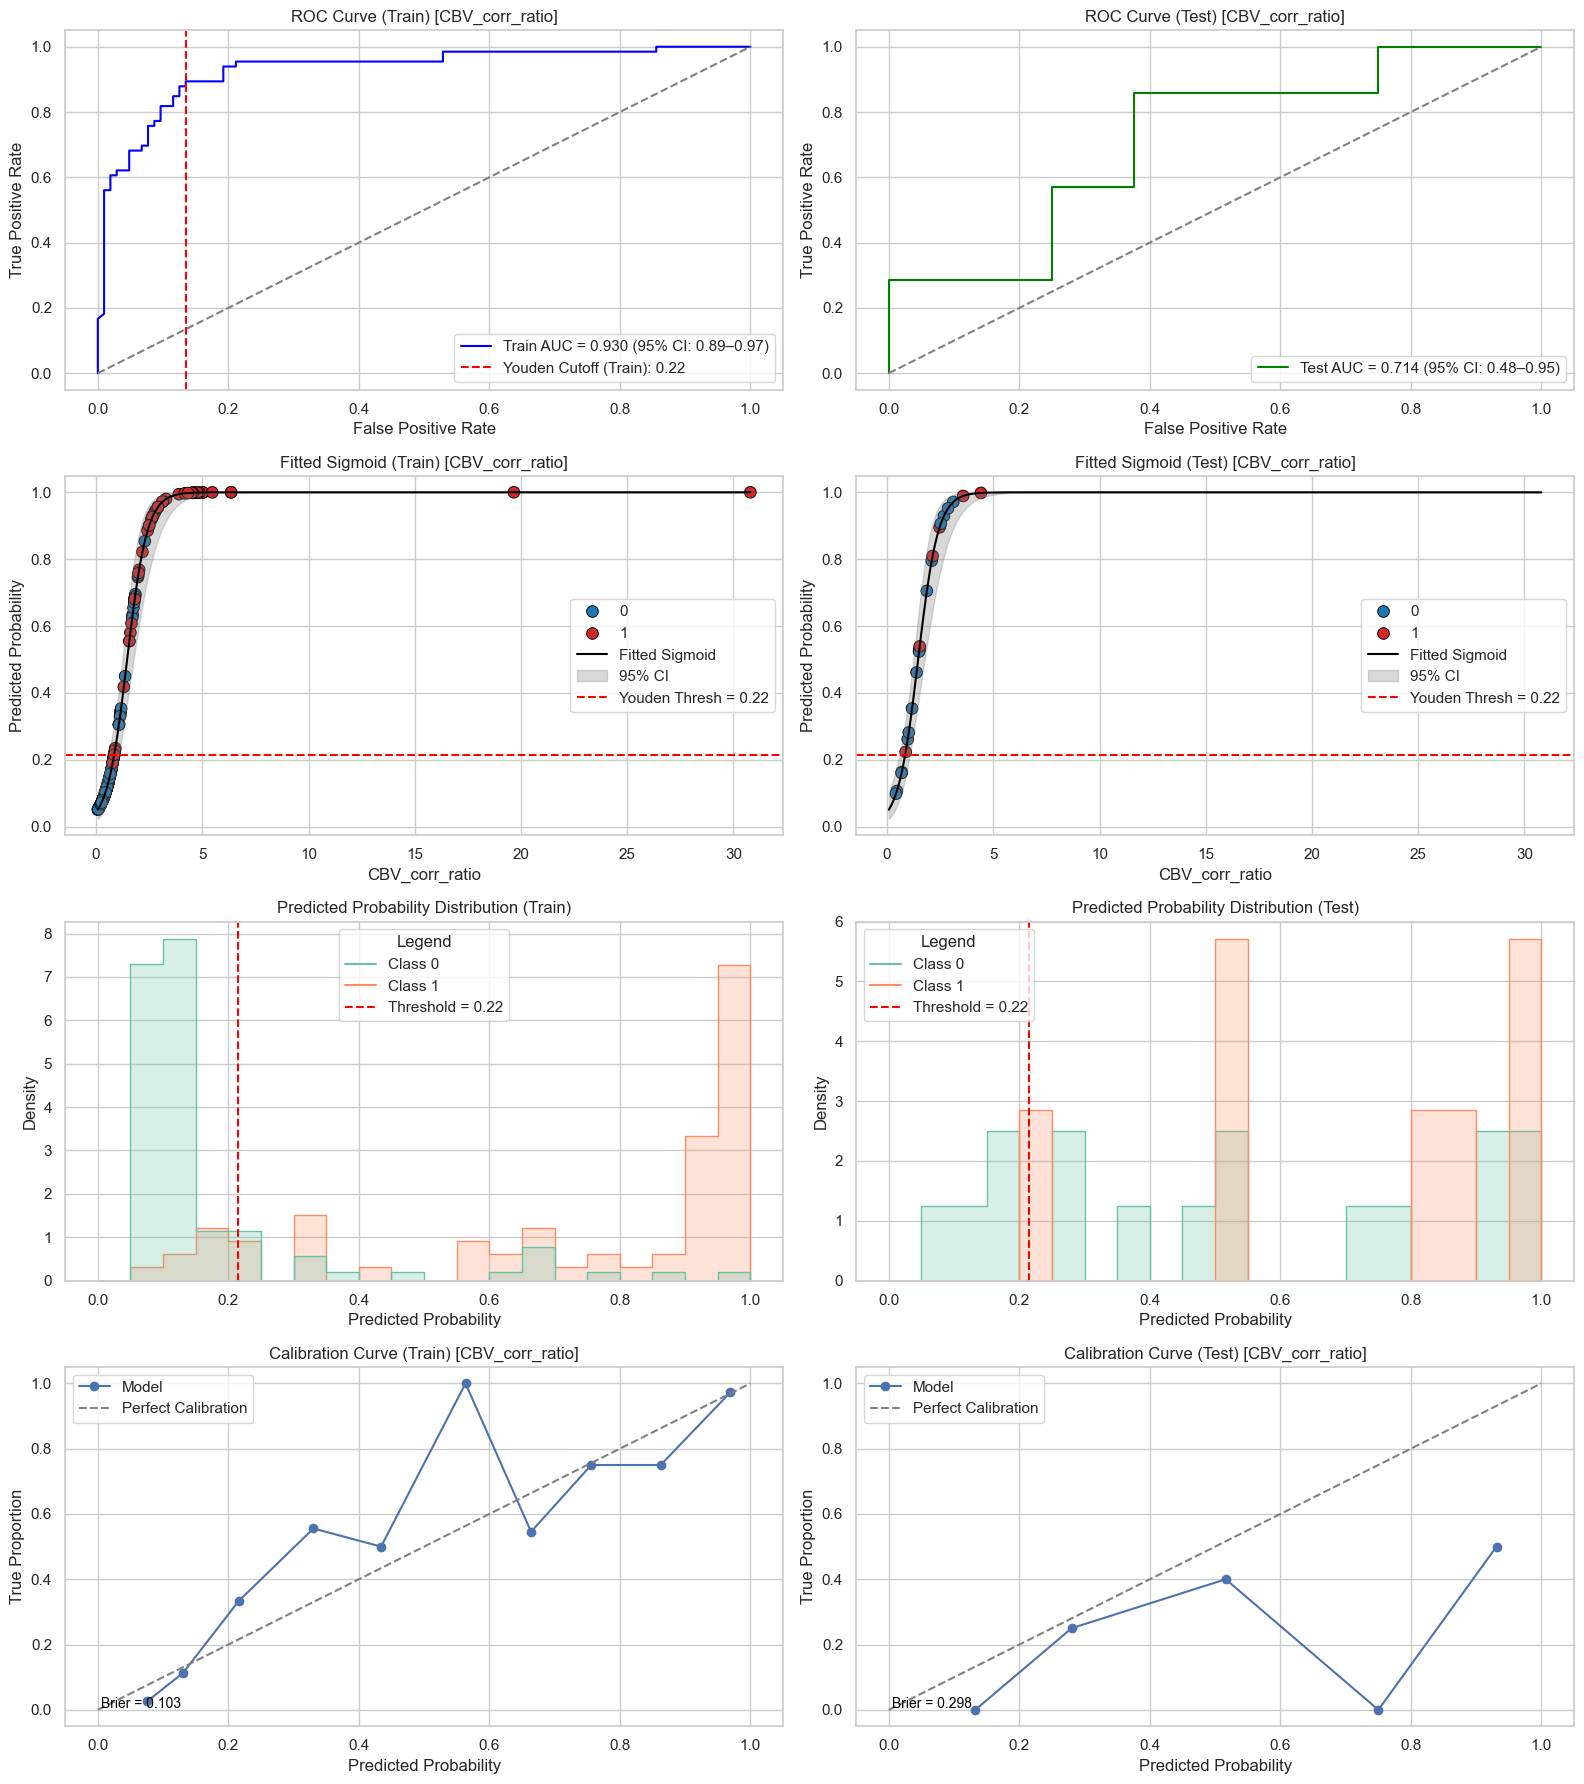

In [20]:
ub.evaluate_logistic_univariate_model(feature=ub.ratio,  target_bin_count=20)

### 5.2 Bivariate Logistic Regression 

BIVARIATE LOGISTIC REGRESSION: CBV_corr_path + CBV_corr_control
----------------------------------------------------------------------------------------------------
AUC (Train): 0.917 (95% CI: 0.872 – 0.963)
AUC (Test) : 0.732 (95% CI: 0.495 – 0.969)
Optimal Threshold (Youden’s J): 0.318

--- Inference Using statsmodels ---
Adjusted ORs per +1 SD (Training scale)
Odds Ratio (CBV_corr_path)     : 8.8115
95% CI for OR (CBV_corr_path)  : (4.3701, 17.7667)
p-value (CBV_corr_path)        : 1.1879e-09
Standard Deviation (CBV_corr_path) used for scaling: 2.93024
Odds Ratio (CBV_corr_control)     : 0.1102
95% CI for OR (CBV_corr_control)  : (0.0453, 0.2681)
p-value (CBV_corr_control)        : 1.1582e-06
Standard Deviation (CBV_corr_control) used for scaling: 1.94459

▶ [CBV_CORR_PATH + CBV_CORR_CONTROL] TRAIN @ 0.5
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      85.3
Recall (Sens

C:\Users\maichi\work\my_projects\CercareStatAnalysis\unibiomarker.py:367: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef_sd = float(logit_model.params[idx])
C:\Users\maichi\work\my_projects\CercareStatAnalysis\unibiomarker.py:373: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pval     = float(pvals[idx])


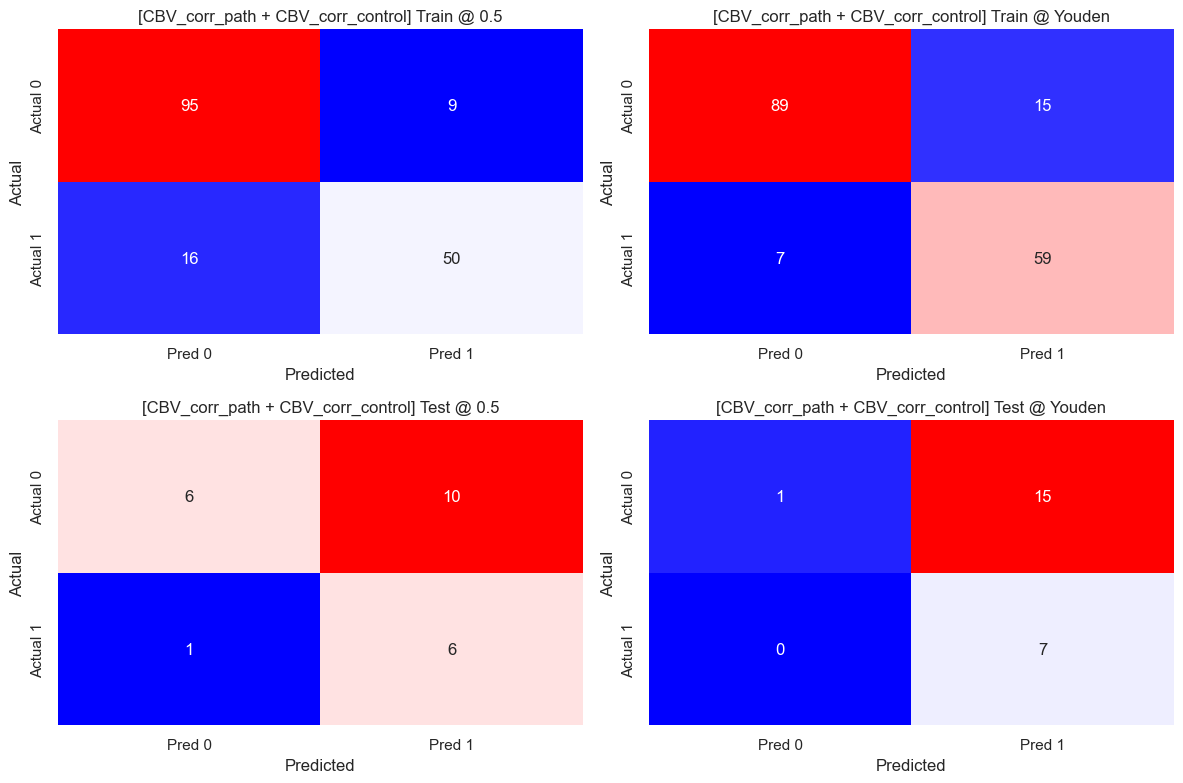

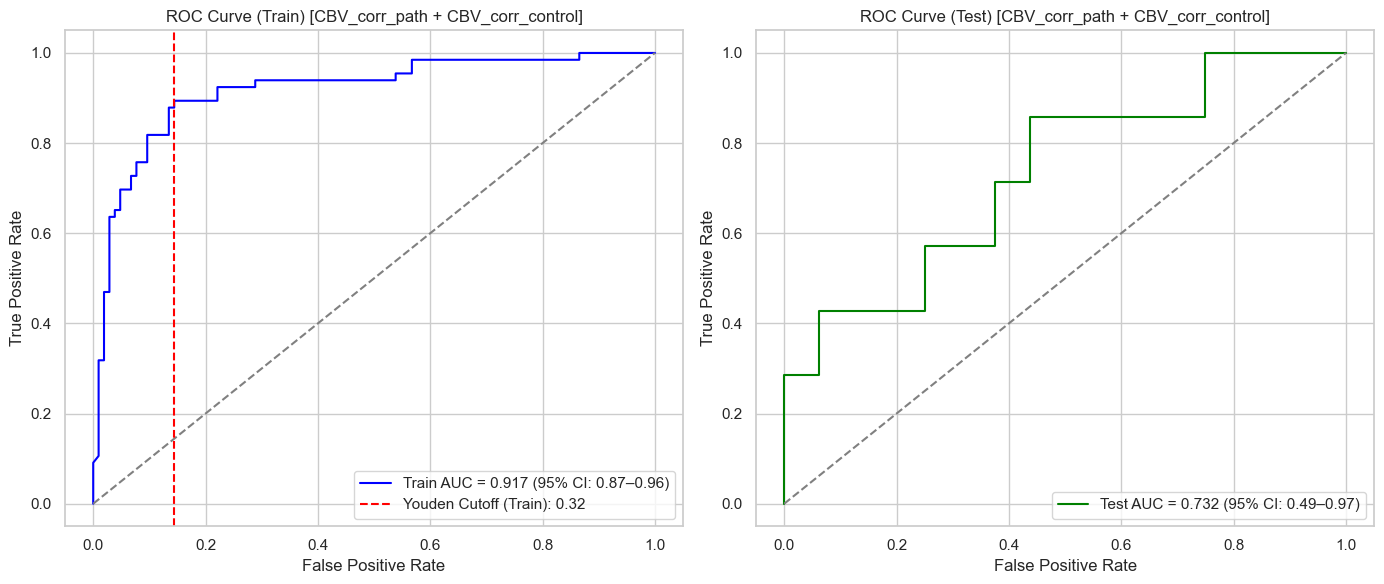

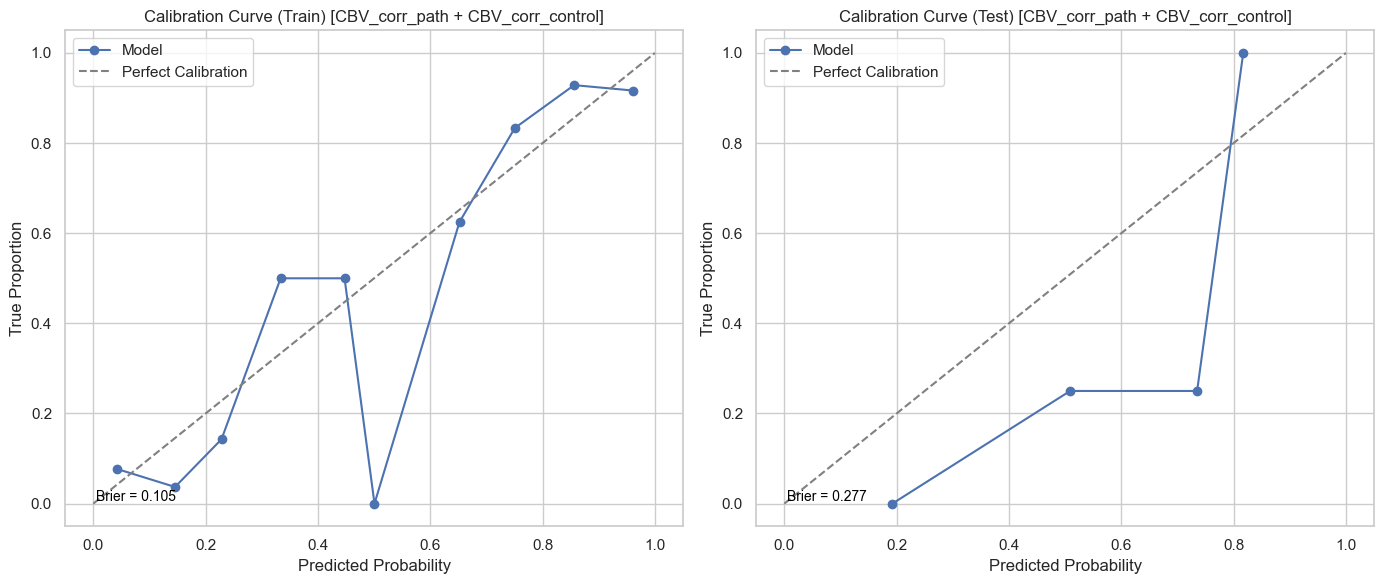

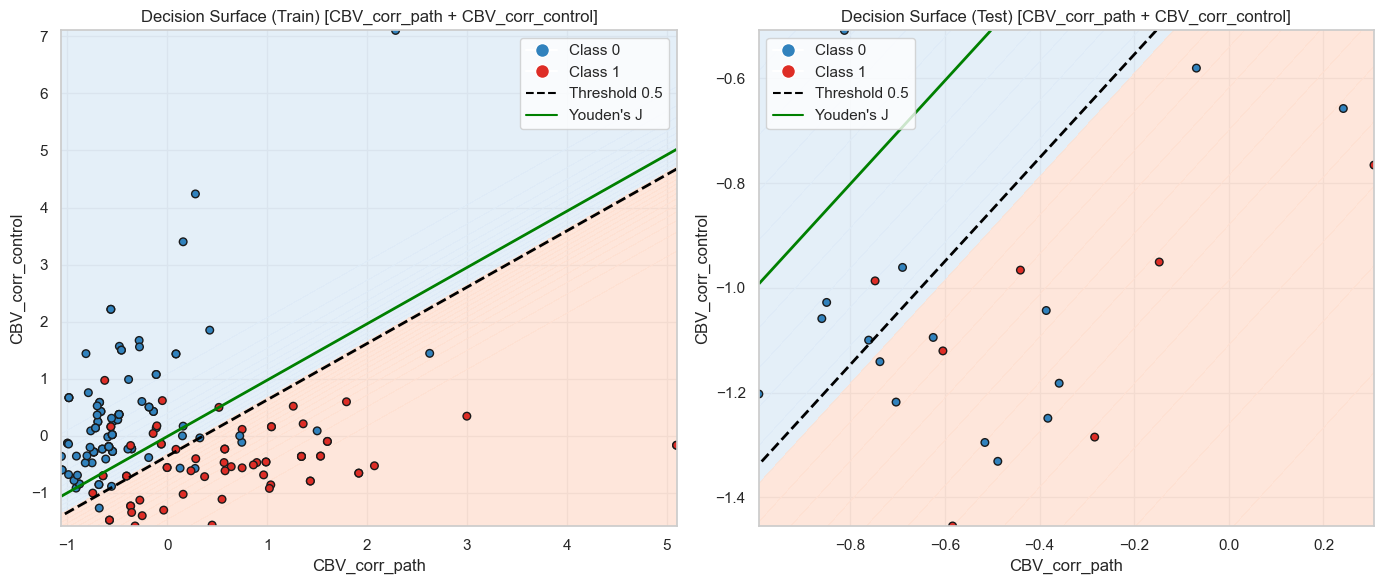

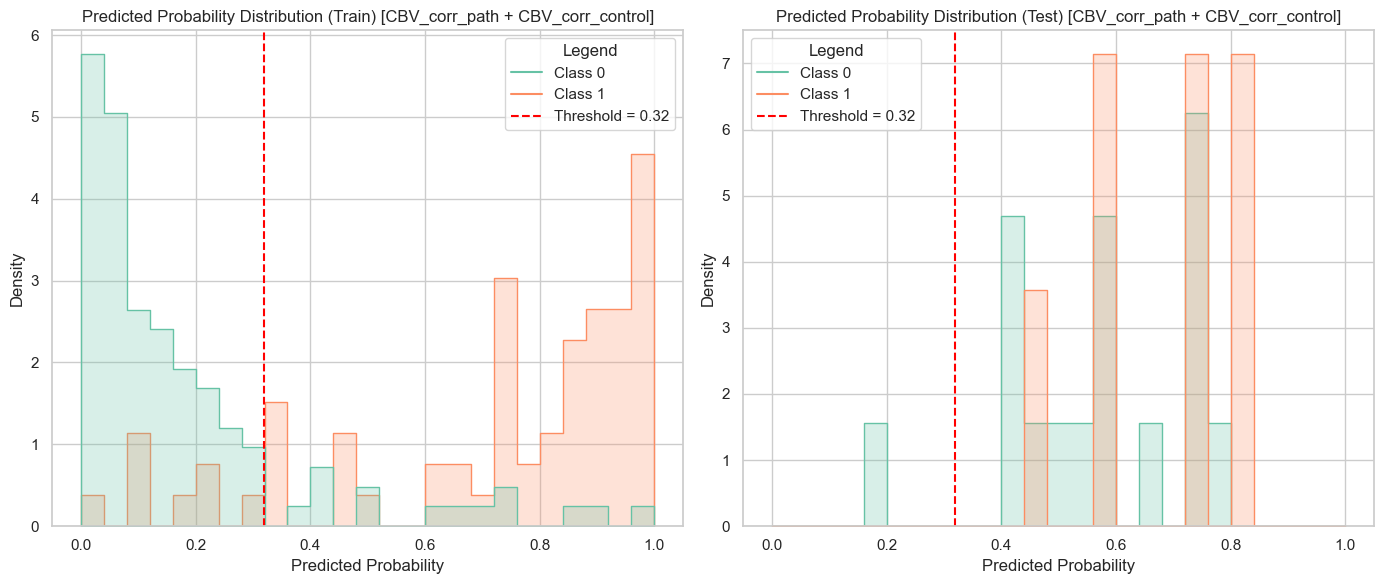

In [21]:
ub.evaluate_logistic_bivariate_model(target_bin_count=25)

## 5.  SVM Modelling

SVM (LINEAR) BIVARIATE: CBV_corr_path + CBV_corr_control
----------------------------------------------------------------------------------------------------
[Margin] Train AUC : 0.918 (95% CI: 0.872 – 0.963)
[Margin] Test  AUC : 0.714 (95% CI: 0.476 – 0.953)
Optimal Margin Cutoff (Youden): -0.461
----------------------------------------------------------------------------------------------------
[Proba]  Train AUC : 0.918 (95% CI: 0.872 – 0.963)
[Proba]  Test  AUC : 0.714 (95% CI: 0.476 – 0.953)
Optimal Proba  Cutoff (Youden): 0.332

▶ [CBV_CORR_PATH + CBV_CORR_CONTROL] TRAIN @ F(X) ≥ 0
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      85.9
Recall (Sensitivity) |      77.3
Specificity          |      91.3
Precision            |      85.0
F1 Score             |      81.0

▶ [CBV_CORR_PATH + CBV_CORR_CONTROL] TRAIN @ F(X) ≥ YOUDEN
--------------------------------------------

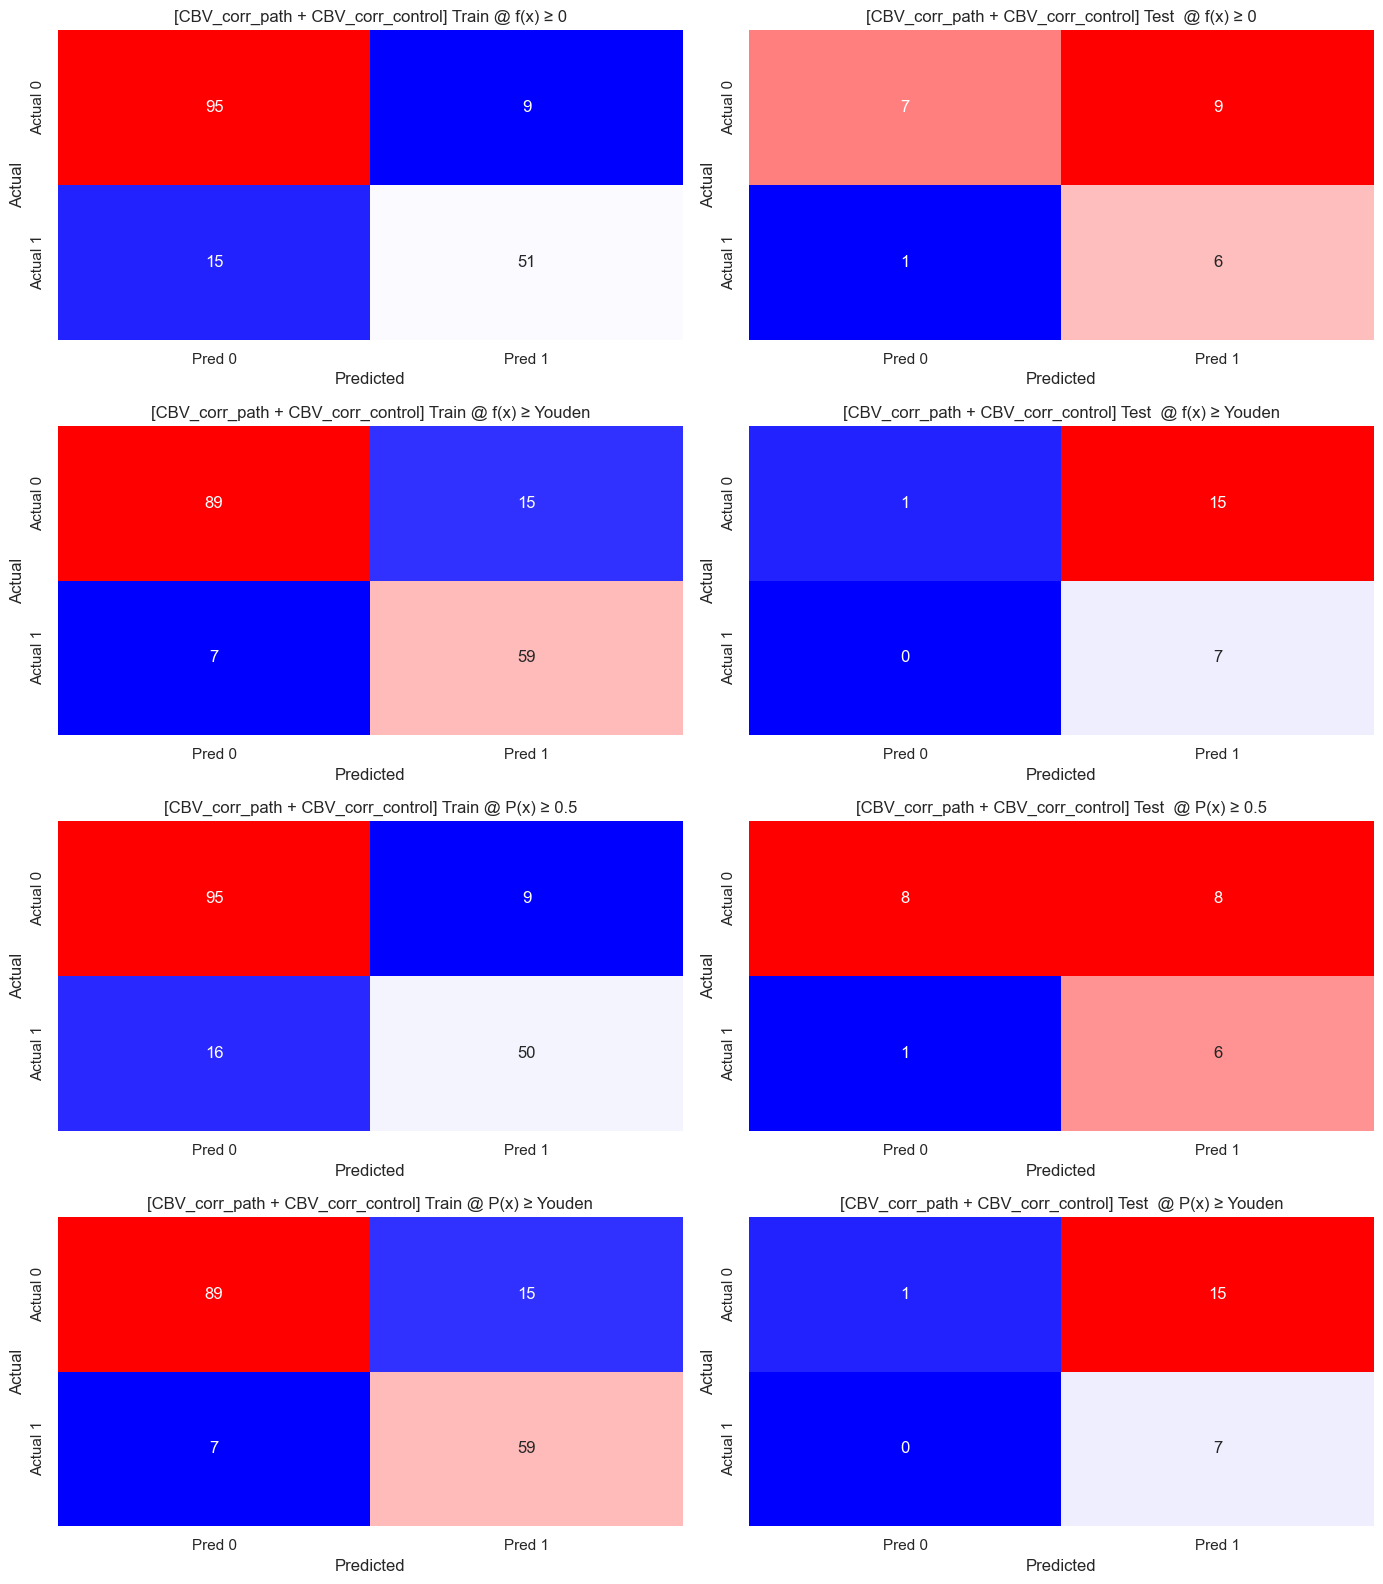

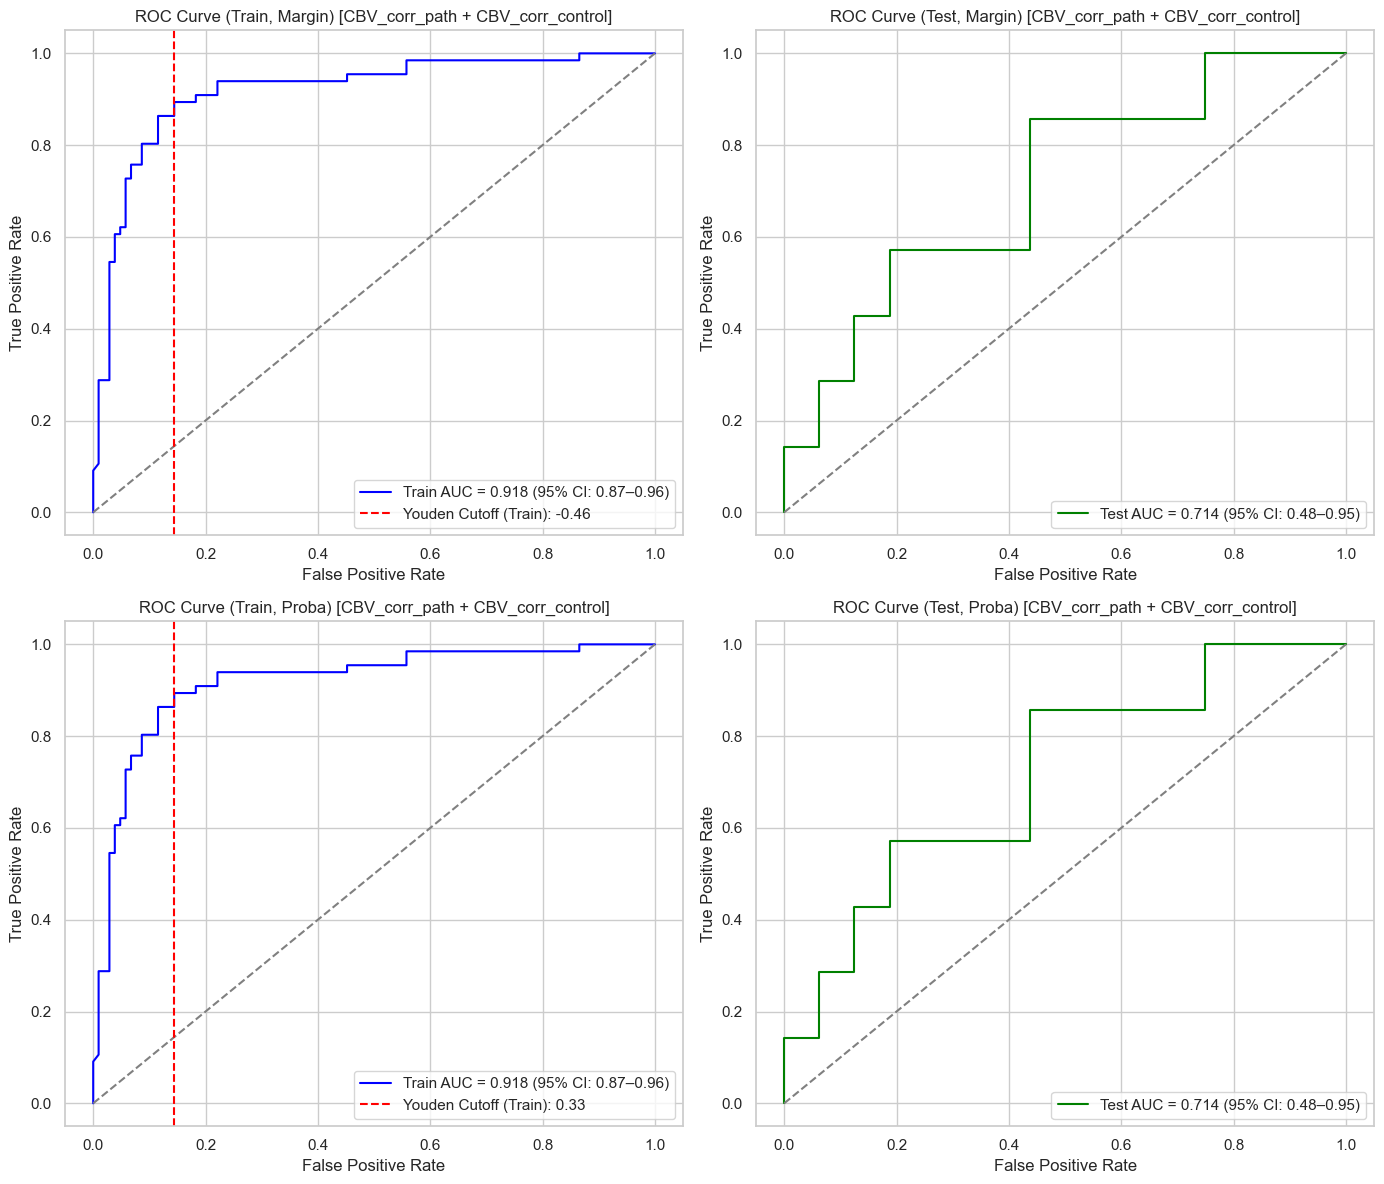

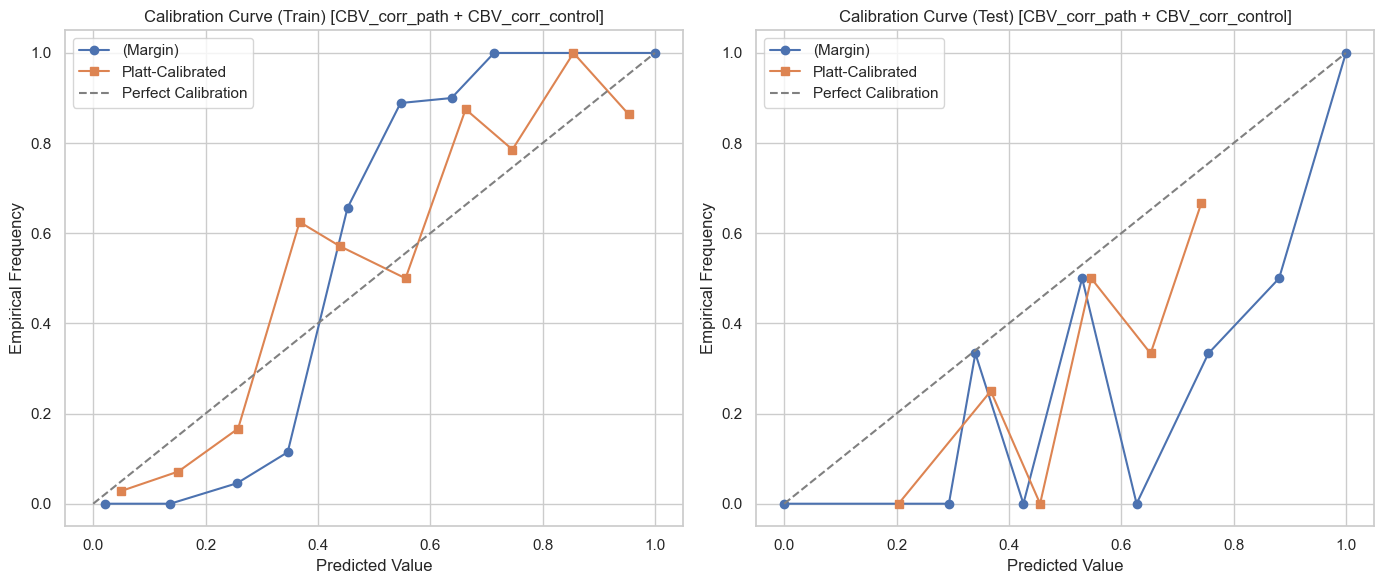

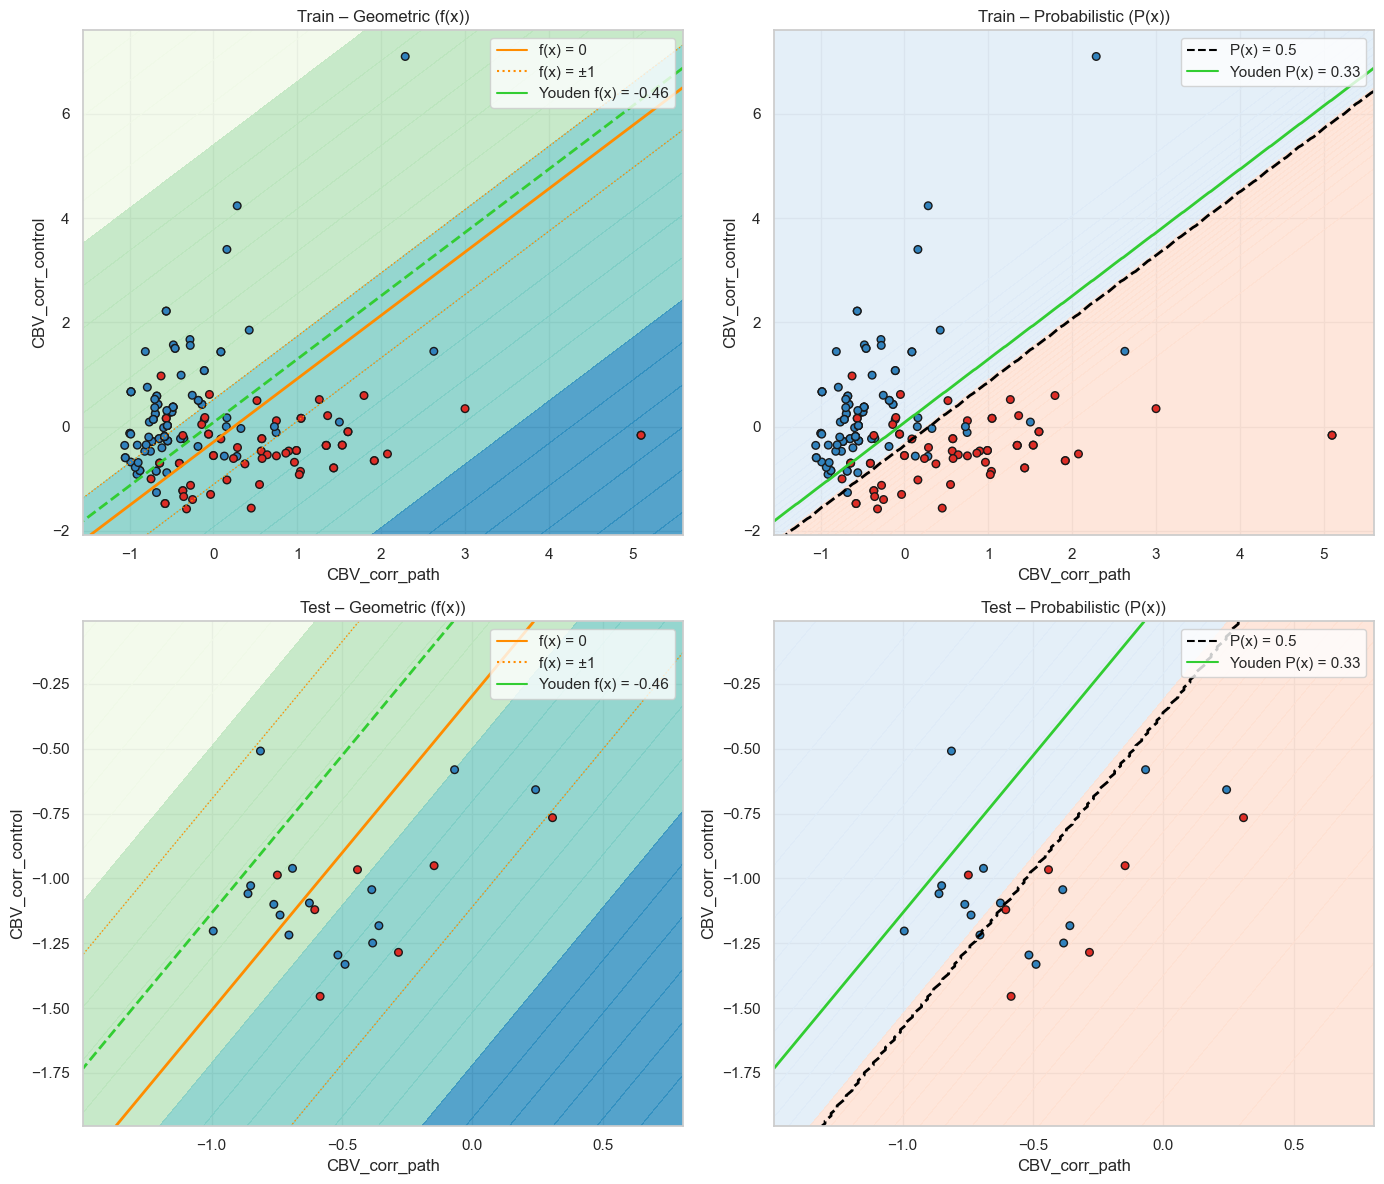

In [22]:
ub.evaluate_svm_bivariate_model(kernel="linear")

SVM (RBF) BIVARIATE: CBV_corr_path + CBV_corr_control
----------------------------------------------------------------------------------------------------
[Margin] Train AUC : 0.929 (95% CI: 0.886 – 0.972)
[Margin] Test  AUC : 0.714 (95% CI: 0.474 – 0.954)
Optimal Margin Cutoff (Youden): -0.659
----------------------------------------------------------------------------------------------------
[Proba]  Train AUC : 0.929 (95% CI: 0.886 – 0.972)
[Proba]  Test  AUC : 0.714 (95% CI: 0.474 – 0.954)
Optimal Proba  Cutoff (Youden): 0.204

▶ [CBV_CORR_PATH + CBV_CORR_CONTROL] TRAIN @ F(X) ≥ 0
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      87.1
Recall (Sensitivity) |      78.8
Specificity          |      92.3
Precision            |      86.7
F1 Score             |      82.5

▶ [CBV_CORR_PATH + CBV_CORR_CONTROL] TRAIN @ F(X) ≥ YOUDEN
-----------------------------------------------

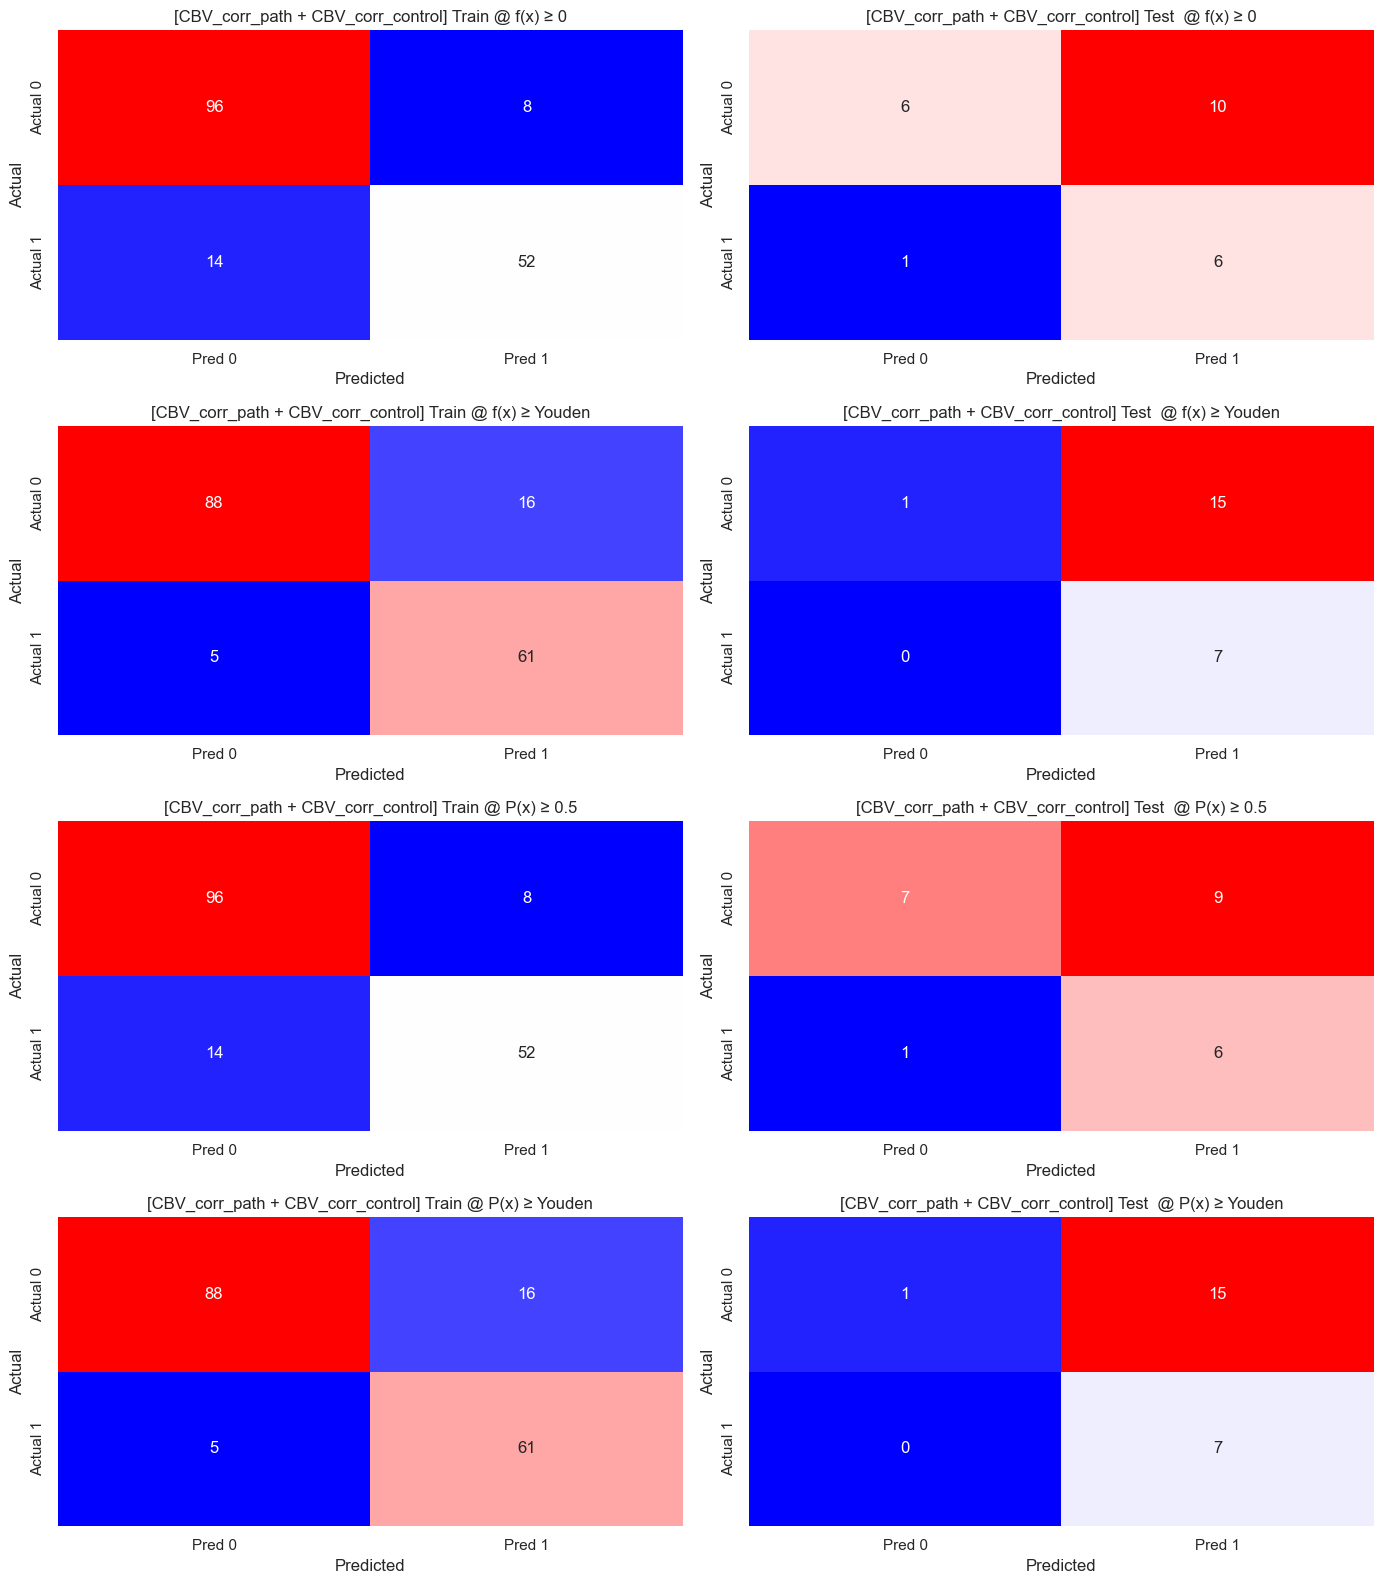

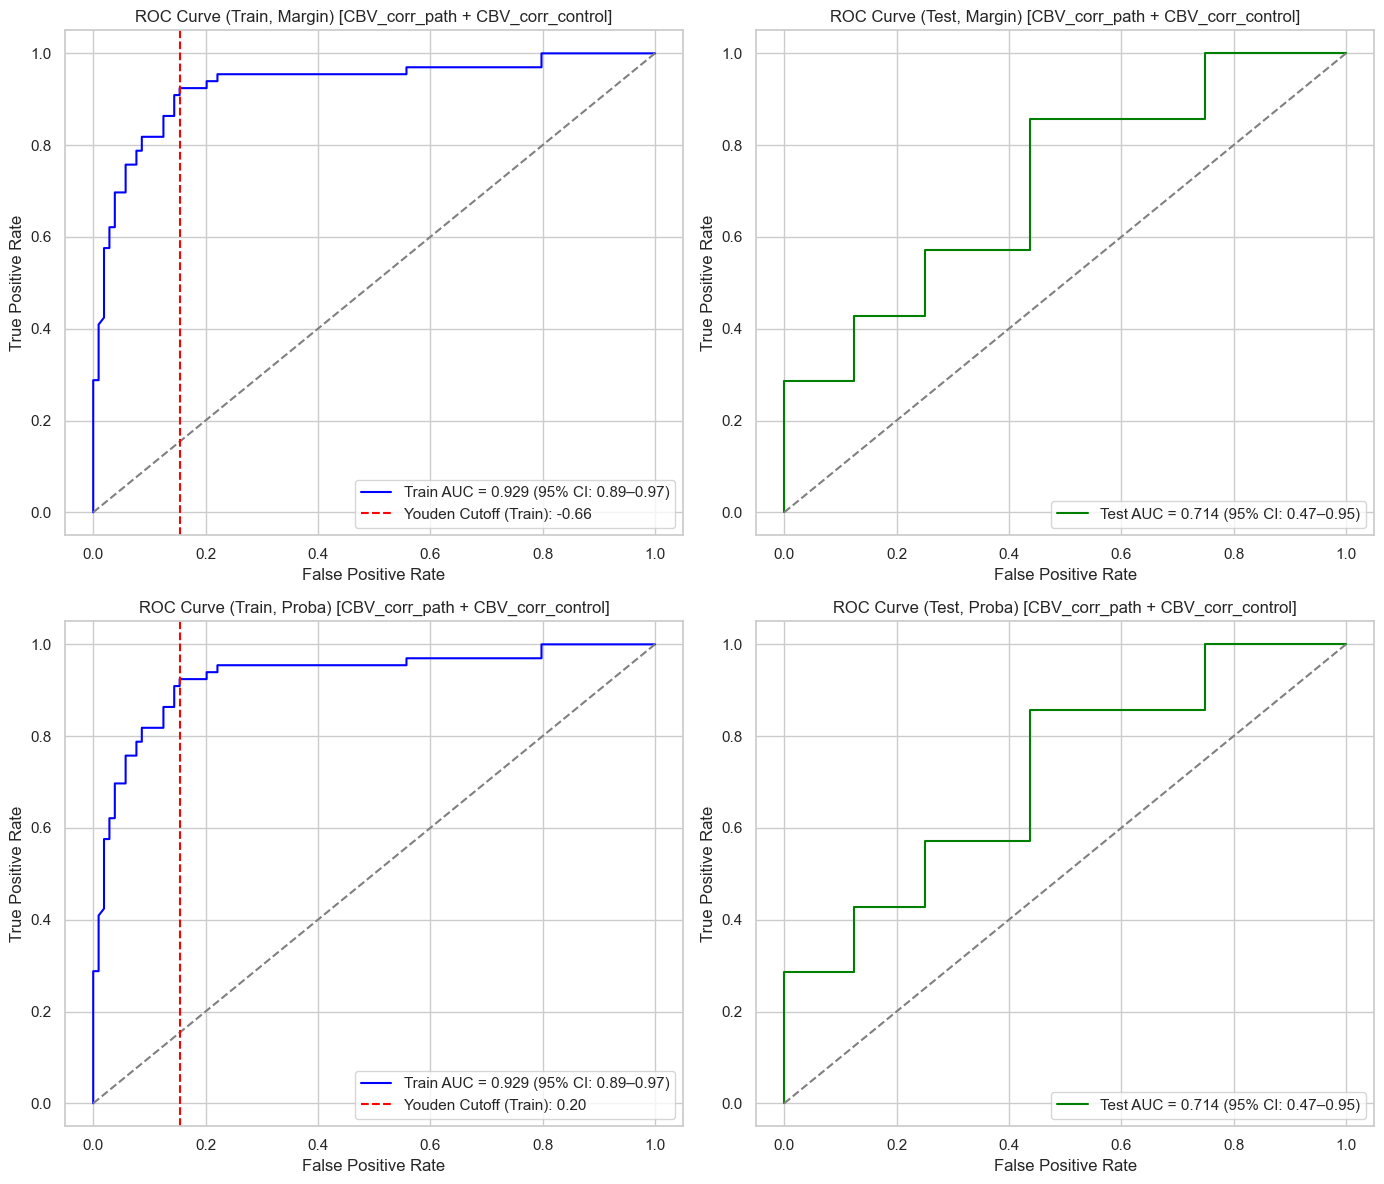

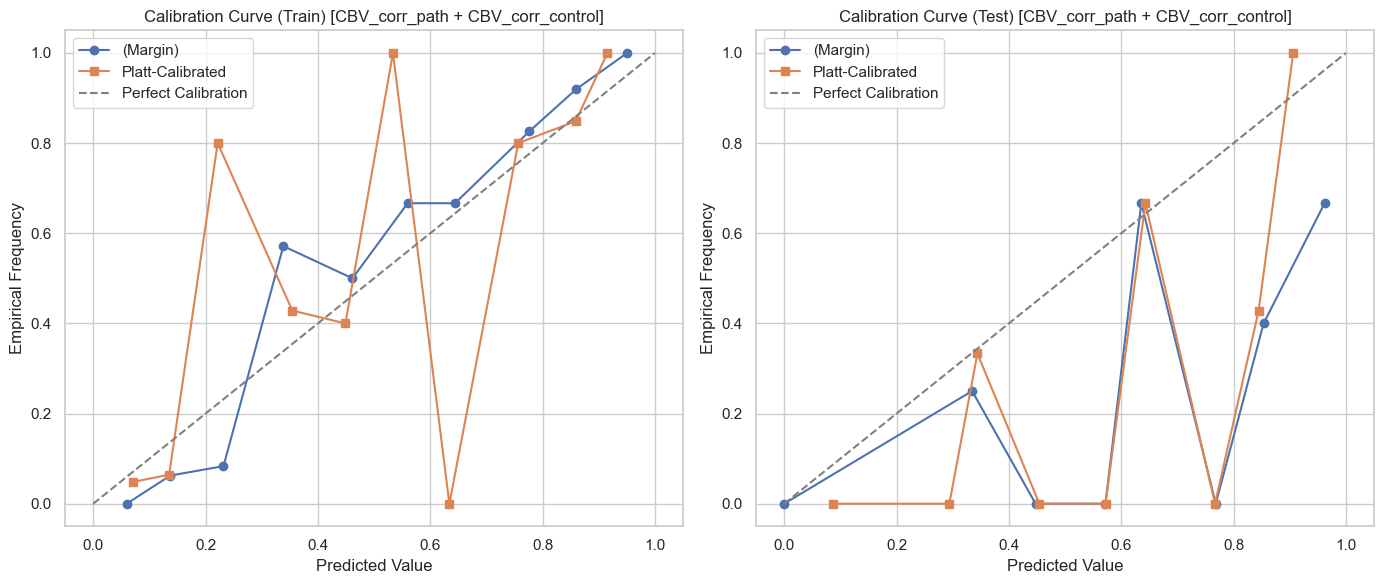

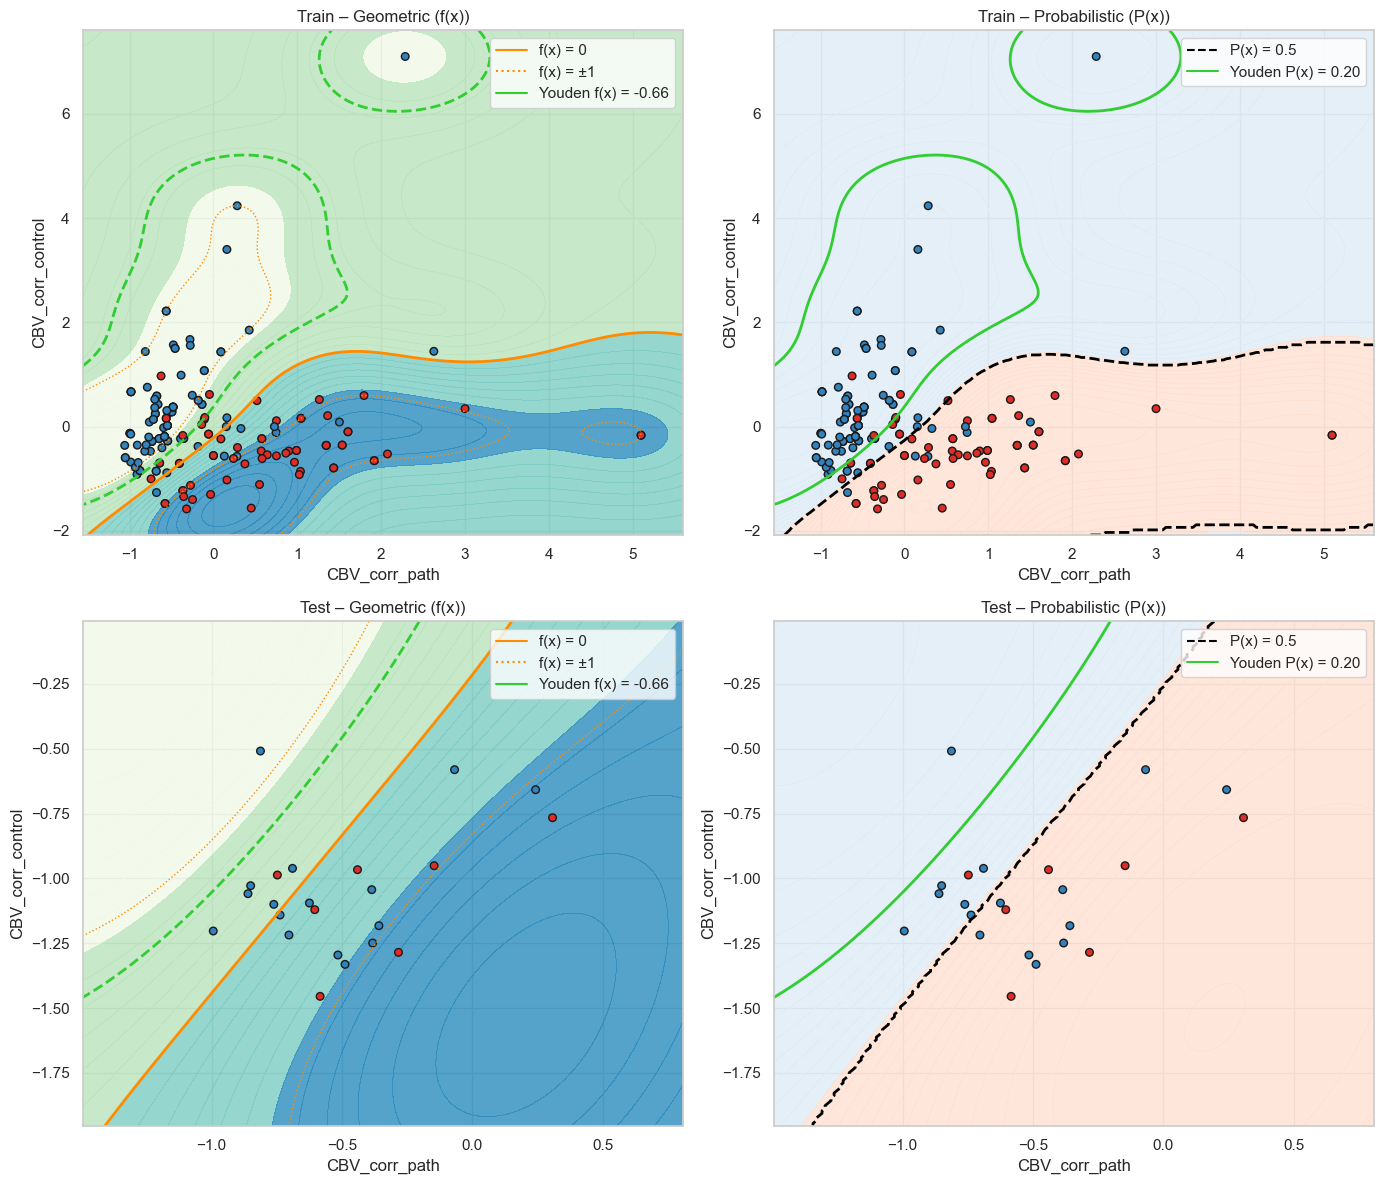

In [23]:
ub.evaluate_svm_bivariate_model(kernel="rbf")

## 6.  Decision Tree Modelling

DECISION TREE (max_depth=3, criterion=GINI): CBV_corr_path + CBV_corr_control + CBV_corr_ratio
----------------------------------------------------------------------------------------------------
AUC (Train): 0.954 (95% CI: 0.928 – 0.980)
AUC (Test) : 0.696 (95% CI: 0.499 – 0.894)
----------------------------------------------------------------------------------------------------

▶ [CBV_CORR_PATH + CBV_CORR_CONTROL + CBV_CORR_RATIO] TRAIN
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      89.4
Recall (Sensitivity) |      95.5
Specificity          |      85.6
Precision            |      80.8
F1 Score             |      87.5

▶ [CBV_CORR_PATH + CBV_CORR_CONTROL + CBV_CORR_RATIO] TEST
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      56.5
Recall (Sensitivity) |    

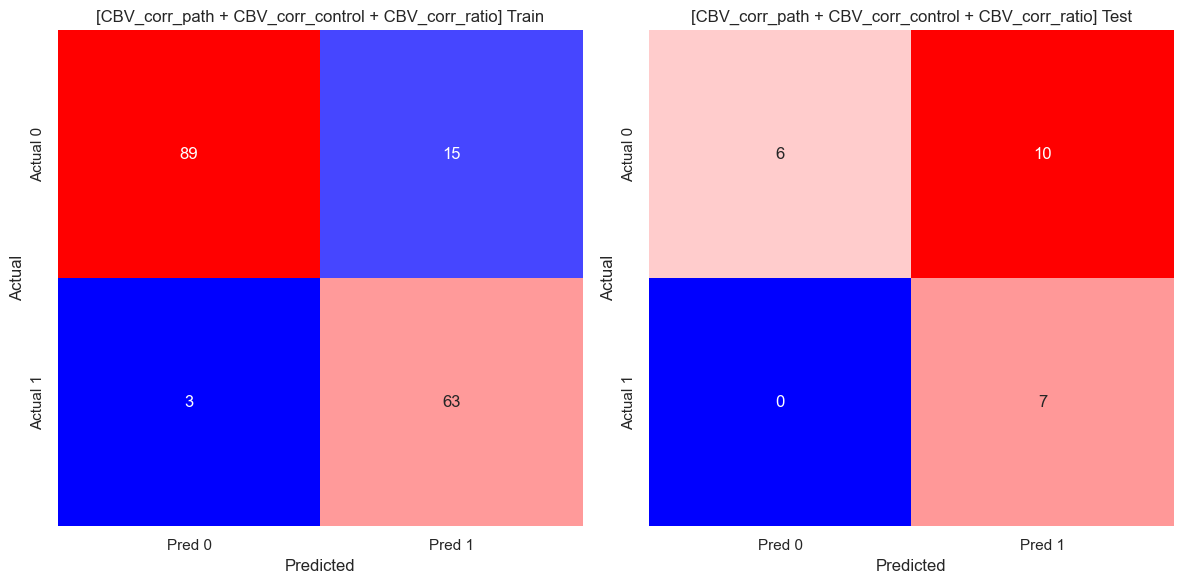

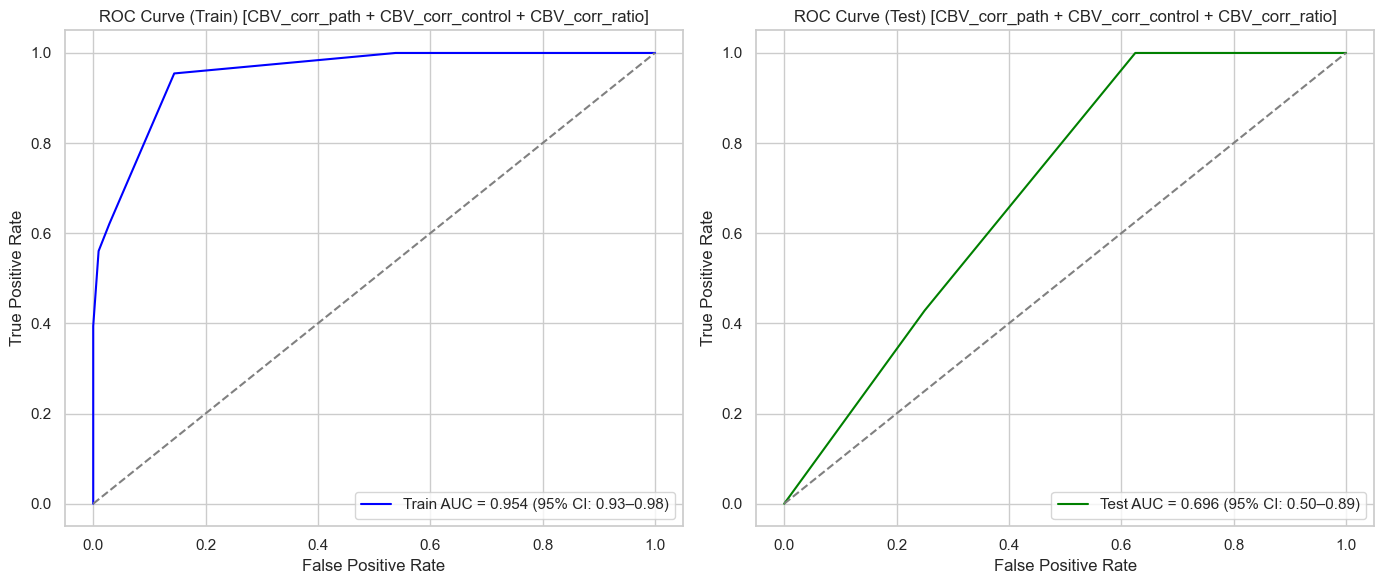

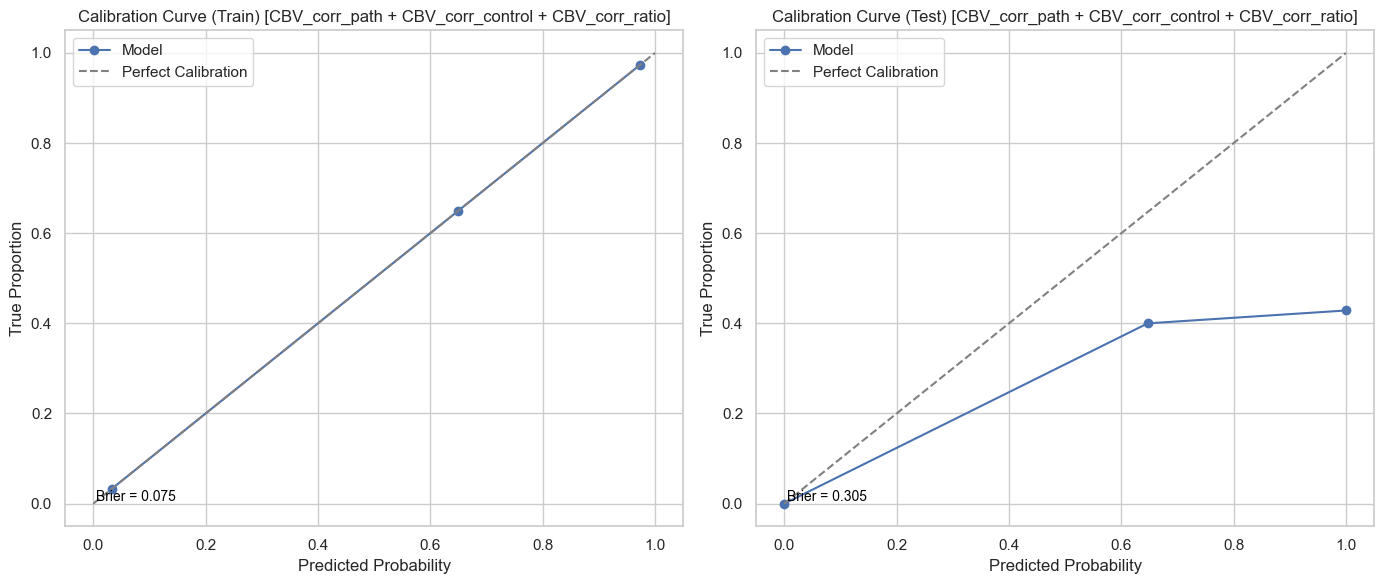

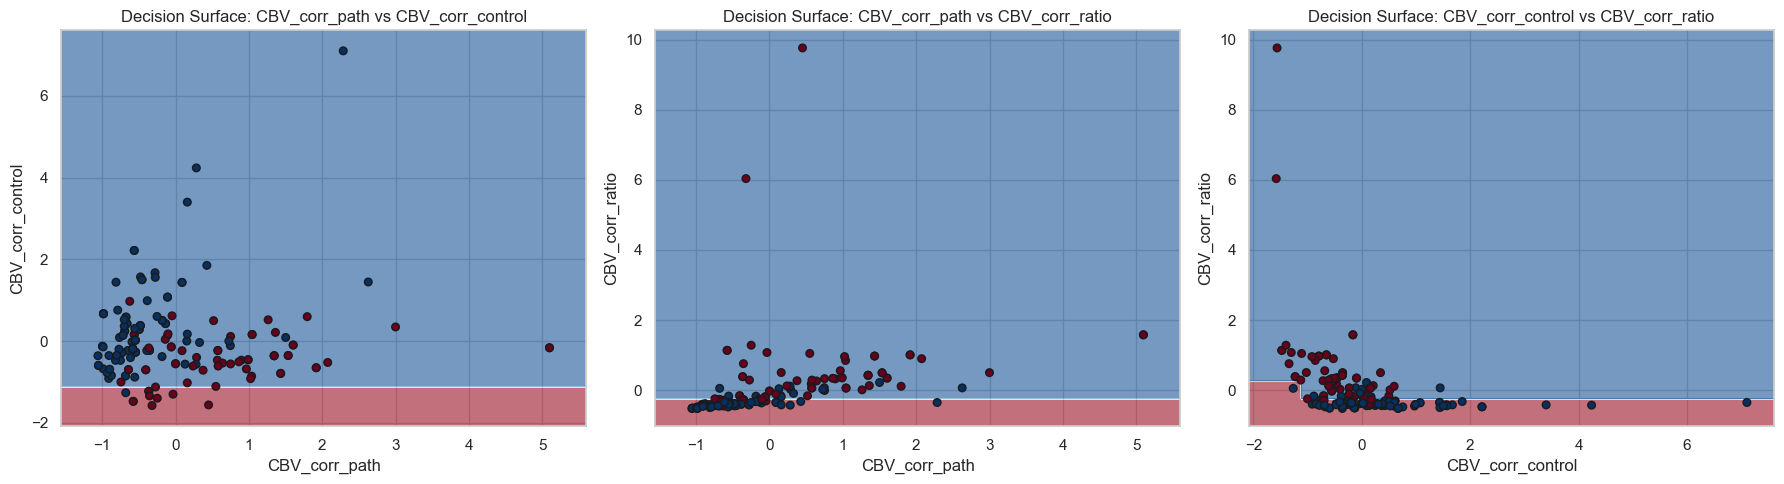

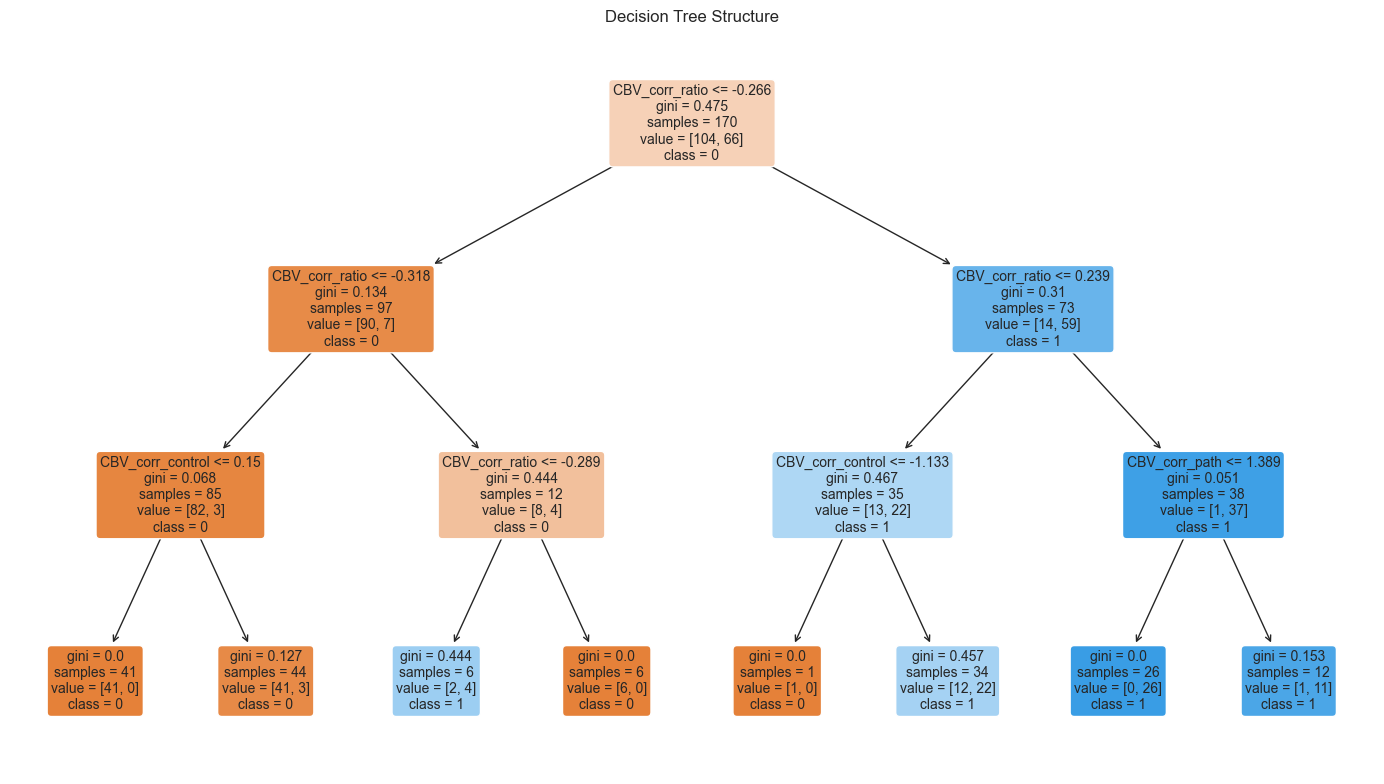


Tree Rules :
--------------------------------------------------------------------------------
|--- CBV_corr_ratio <= -0.27
|   |--- CBV_corr_ratio <= -0.32
|   |   |--- CBV_corr_control <= 0.15
|   |   |   |--- class: 0
|   |   |--- CBV_corr_control >  0.15
|   |   |   |--- class: 0
|   |--- CBV_corr_ratio >  -0.32
|   |   |--- CBV_corr_ratio <= -0.29
|   |   |   |--- class: 1
|   |   |--- CBV_corr_ratio >  -0.29
|   |   |   |--- class: 0
|--- CBV_corr_ratio >  -0.27
|   |--- CBV_corr_ratio <= 0.24
|   |   |--- CBV_corr_control <= -1.13
|   |   |   |--- class: 0
|   |   |--- CBV_corr_control >  -1.13
|   |   |   |--- class: 1
|   |--- CBV_corr_ratio >  0.24
|   |   |--- CBV_corr_path <= 1.39
|   |   |   |--- class: 1
|   |   |--- CBV_corr_path >  1.39
|   |   |   |--- class: 1



In [24]:
ub.evaluate_tree_trivariate_model()